# Optimise tagging particle selection for the OSElectron

- Author:      Vincenzo Battista (vibattis)
- Start Date:  12/12/2017 
- End Date:     

## Goals
- use the average tagging power as a FoM for the tagging particle optimisation of the OS Electron tagger

## Conclusion
- after some attempts, gradient boosting from scikit-optimize seems to be the best optimizer

In [1]:
# https://ipython.org/ipython-doc/dev/config/extensions/autoreload.html
%reload_ext autoreload
%autoreload 2

# profiling
%reload_ext line_profiler

# https://github.com/jrjohansson/version_information
%reload_ext version_information
%version_information numpy, scipy, matplotlib, pandas

import matplotlib
matplotlib.rc_file('../../lhcb-matplotlibrc/matplotlibrc')
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)
%config InlineBackend.figure_format = 'retina'

In [2]:
# import modules
import os
import sys

import math
from uncertainties import ufloat

import numpy as np

from root_pandas import read_root, to_root

#import matplotlib.pyplot as plt
#import seaborn as sns

from scipy.optimize import minimize
from skopt import gbrt_minimize, dump, load  

from sklearn.cross_validation import train_test_split

from functools import partial
from skopt.plots import plot_convergence

from sklearn.model_selection import train_test_split

import pandas as pd

#Set up logging
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

/afs/cern.ch/work/v/vibattis/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#"Local" library import
sys.path.append("../../python/")
import calib_models, calib_utils, data_utils, plot_utils, tagging_utils

In [4]:
#Set LHCb style for plots
#import matplotlib
#matplotlib.rc_file('../../lhcb-matplotlibrc/matplotlibrc')

In [5]:
# Customizations
#sns.set() # matplotlib defaults

# Any tweaks that normally go in .matplotlibrc, etc., should explicitly go here
#%matplotlib inline 
#plt.rcParams['figure.figsize'] = (12, 12)
#%config InlineBackend.figure_format='retina'

In [6]:
# notebook name
notebook_name = '2017-12-12-vibattis-OSElectron-tagpartseloptimisation_Run2'
# Find the notebook the saved figures came from
fig_prefix = '../figures/'+notebook_name+'/'
data_prefix = '../data/'+notebook_name+'/'
weight_prefix = '../weights/'+notebook_name+'/'
chunksize = 5000
maxslices = None

In [7]:
# input file and tree names
file_in_path = '/eos/lhcb/wg/FlavourTagging/tuples/development/data/B2CC/20170628_kheinick/DTT_2016_Reco16Strip28_20170628_kheinicke_sweights.root'
tree_in = 'Bu2JpsiKDetached'
file_out_path_bdt = '/afs/cern.ch/work/v/vibattis/public/OSElectronOpt2017/OptCutsNominalRun2/Selected_Bu2JpsiK_OSe_bdt.root'
file_out_path_eval1 = '/afs/cern.ch/work/v/vibattis/public/OSElectronOpt2017/OptCutsNominalRun2/Selected_Bu2JpsiK_OSe_eval1.root'
file_out_path_eval2 = '/afs/cern.ch/work/v/vibattis/public/OSElectronOpt2017/OptCutsNominalRun2/Selected_Bu2JpsiK_OSe_eval2.root'

In [8]:
data_kwargs = dict(
    key=tree_in,  # the tree name
    columns=['B_OSMuonDev_TagPartsFeature*',
             'B_ID',
             'B_PT',
             'SigYield_sw',
             'runNumber',
             'eventNumber',
             'nCandidate'
            ],
    chunksize=chunksize,
    where='B_LOKI_MASS_JpsiConstr_NoPVConstr>0',#&&eventNumber%6==0',  # a ROOT where selection, does not work with array-variables
    flatten=True,  # will flatten the data in the dimension of the first given column
)

## Create OSElectron subsample and selection query

In [1]:
#A reasonable preselection
query = 'B_OSMuonDev_TagPartsFeature_IsSignalDaughter == 0 \
         & B_OSMuonDev_TagPartsFeature_MuonPIDIsMuon == 0 \
         & B_OSMuonDev_TagPartsFeature_TRCHI2DOF <3. \
         & B_OSMuonDev_TagPartsFeature_PP_InAccHcal == 1 \
         & B_OSMuonDev_TagPartsFeature_PP_VeloCharge >0 \
         & B_OSMuonDev_TagPartsFeature_PP_VeloCharge < 1.4 \
         & B_OSMuonDev_TagPartsFeature_IPErr != 0 \
         & B_OSMuonDev_TagPartsFeature_eOverP < 2 \
         & B_OSMuonDev_TagPartsFeature_eOverP > 0.85 \
         & B_OSMuonDev_TagPartsFeature_TRTYPE == 3'

In [2]:
#Print in python format (ready for copy-paste)"
query_toprint = query.replace("B_OSMuonDev_TagPartsFeature_","")
query_toprint = query_toprint.replace(" ","")
query_toprint = query_toprint.split("&")
for q in query_toprint:
    print(f'\"{q}\",')

"IsSignalDaughter==0",
"MuonPIDIsMuon==0",
"TRCHI2DOF<3.",
"PP_InAccHcal==1",
"PP_VeloCharge>0",
"PP_VeloCharge<1.4",
"IPErr!=0",
"eOverP<2",
"eOverP>0.85",
"TRTYPE==3",


In [10]:
splits = ['eventNumber % 8 >= 0 & eventNumber % 8 <= 1', #train cut selection
          'eventNumber % 8 >= 2 & eventNumber % 8 <= 5', #BDT and cross-validation
          'eventNumber % 8 == 6',  #independent evaluation (1)
          'eventNumber % 8 == 7']  #independent evaluation (2)

In [11]:
from data_utils import read_and_split
N_evt, N_evt_split, df_selected, df_split_selected = read_and_split(file_in_path,
                                                                    tree_in,
                                                                    data_kwargs,
                                                                    query,
                                                                    splits,
                                                                    maxslices=maxslices,
                                                                    chunksize=chunksize)

  0%|          | 0/450.4922 [00:00<?, ?it/s]/afs/cern.ch/work/v/vibattis/miniconda3/lib/python3.6/site-packages/root_pandas/readwrite.py:181: FutureWarning:  The option flatten=True is deprecated. Please specify the branches you would like to flatten in a list: flatten=['foo', 'bar']
  "to flatten in a list: flatten=['foo', 'bar']", FutureWarning)
451it [1:11:15, 15.49s/it]                              

INFO:data_utils:Total events before selection: 1134050.756982364
INFO:data_utils:...split: eventNumber % 8 >= 0 & eventNumber % 8 <= 1, events 283556.5176535152
INFO:data_utils:...split: eventNumber % 8 >= 2 & eventNumber % 8 <= 5, events 566948.5608852252
INFO:data_utils:...split: eventNumber % 8 == 6, events 141892.89286606023
INFO:data_utils:...split: eventNumber % 8 == 7, events 141652.78557756357


INFO:data_utils:Total events after selection: 970908.932990915
INFO:data_utils:...split: eventNumber % 8 >= 0 & eventNumber % 8 <= 1, events 242921.3630264732
INFO:data_utils:...split: eventNumber % 8 >= 2 & eventNumber % 8 <= 5, events 485220.64719378523
INFO:data_utils:...split: eventNumber % 8 == 6, events 121598.22299622174
INFO:data_utils:...split: eventNumber % 8 == 7, events 121168.69977443434


In [12]:
N_evt_train = N_evt_split[0]
N_evt_bdt = N_evt_split[1]
N_evt_eval1 = N_evt_split[2]
N_evt_eval2 = N_evt_split[3]

df_selected_train = df_split_selected[0]
df_selected_bdt = df_split_selected[1]
df_selected_eval1 = df_split_selected[2]
df_selected_eval2 = df_split_selected[3]

## Optimize cut values with minimizers

### SciKit Optimize documentation
see https://scikit-optimize.github.io

### Optimize full selection using "gradient boosting"

In [13]:
query_str_wph =  'B_OSMuonDev_TagPartsFeature_P/1000 > {}'+' & '+ \
                 'B_OSMuonDev_TagPartsFeature_PT/1000 > {}'+' & '+ \
                 'B_OSMuonDev_TagPartsFeature_TRGHP < {}'+' & '+ \
                 'B_OSMuonDev_TagPartsFeature_minPhiDistance >= {}'+' & '+ \
                 'B_OSMuonDev_TagPartsFeature_IPSig > {}'+' & '+ \
                 'B_OSMuonDev_TagPartsFeature_PROBNNmu_MC15TuneV1 < {} '+' & '+ \
                 'B_OSMuonDev_TagPartsFeature_PROBNNpi_MC15TuneV1 < {}'+' & '+ \
                 'B_OSMuonDev_TagPartsFeature_PROBNNk_MC15TuneV1 < {}'+' & '+ \
                 'B_OSMuonDev_TagPartsFeature_PROBNNp_MC15TuneV1 < {}'+' & '+ \
                 'B_OSMuonDev_TagPartsFeature_PROBNNe_MC15TuneV1 > {}'+' & '+ \
                 'B_OSMuonDev_TagPartsFeature_IPPUSig > {}'+' & '+ \
                 '(B_OSMuonDev_TagPartsFeature_PIDe + 5) > {}'+' & '+ \
                 '(B_OSMuonDev_TagPartsFeature_PROBNNe_MC15TuneV1 - B_OSMuonDev_TagPartsFeature_PROBNNpi_MC15TuneV1 + 2) > {}'

In [14]:
from tagging_utils import TagPowerCalc
tagpowercalc_electron = TagPowerCalc(df_selected_train, query_str_wph, N_evt_train)

In [15]:
x0_gp = [0.0,   #P 
         1.1,   #PT 
         0.4,   #TRGHP
         0.005, #minPhiDistance
         3.5,   #IPSig
         0.8,   #PROBNNmu
         0.8,   #PROBNNpi
         0.8,   #PROBNNk
         0.8,   #PROBNNp
         0.1,   #PROBNNe
         4.0,   #IPPUSig
         4.0,   #PIDe+5
         1.2]   #PROBNNe - PROBNNpi + 2
x0_gp_limits = [(0.,10.),    #P
                (0.,10.),    #PT 
                (0.,1.),     #TRGHP
                (0.,0.5),    #minPhiDistance
                (0.01,10.),  #IPSig
                (0.1,0.99),  #PROBNNmu
                (0.1,0.99),  #PROBNNpi
                (0.1,0.99),  #PROBNNk
                (0.1,0.99),  #PROBNNp
                (0.01,0.9),  #PROBNNe 
                (0., 10.0),  #IPPUSig
                (0., 20.0),  #PIDe+5
                (0.,2.0)]    #PROBNNe - PROBNNpi + 2

In [16]:
res_gbrt = gbrt_minimize(tagpowercalc_electron.evaluate, 
                         x0_gp_limits, 
                         n_calls=8000, 
                         n_random_starts=10, 
                         x0=x0_gp, 
                         random_state=42, 
                         n_jobs=-1,
                         verbose=True)

Iteration No: 1 started. Evaluating function at provided point.
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 0.1701
Function value obtained: -0.0010
Current minimum: -0.0010
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0950
Function value obtained: -0.0000
Current minimum: -0.0010
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0876
Function value obtained: -0.0003
Current minimum: -0.0010
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0837
Function value obtained: -0.0000
Current minimum: -0.0010
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0856
Function value obtained: -0.0001
Current minimum: -0.0010
Iteration No: 6 start

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 0.4166
Function value obtained: -0.0012
Current minimum: -0.0021
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.3326
Function value obtained: -0.0017
Current minimum: -0.0021
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 0.4732
Function value obtained: -0.0017
Current minimum: -0.0021
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 0.6174
Function value obtained: -0.0003
Current minimum: -0.0021
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.4516
Function value obtained: -0.0010
Current minimum: -0.0021
Iteration No: 46 st

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 0.5170
Function value obtained: -0.0011
Current minimum: -0.0023
Iteration No: 82 started. Searching for the next optimal point.
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 0.4525
Function value obtained: -0.0021
Current minimum: -0.0023
Iteration No: 83 started. Searching for the next optimal point.
Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 0.3463
Function value obtained: -0.0016
Current minimum: -0.0023
Iteration No: 84 started. Searching for the next optimal point.
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 0.5091
Function value obtained: -0.0001
Current minimum: -0.0023
Iteration No: 85 started. Searching for the next optimal point.
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 0.4575
Function value obtained: -0.0021
Current minimum: -0.0023
Iteration No: 86 st

Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 0.4627
Function value obtained: -0.0020
Current minimum: -0.0023
Iteration No: 121 started. Searching for the next optimal point.
Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 0.4253
Function value obtained: -0.0000
Current minimum: -0.0023
Iteration No: 122 started. Searching for the next optimal point.
Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 0.4516
Function value obtained: -0.0001
Current minimum: -0.0023
Iteration No: 123 started. Searching for the next optimal point.
Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 0.4958
Function value obtained: -0.0012
Current minimum: -0.0023
Iteration No: 124 started. Searching for the next optimal point.
Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 0.5478
Function value obtained: -0.0019
Current minimum: -0.0023
Iteration 

Iteration No: 159 ended. Search finished for the next optimal point.
Time taken: 0.4586
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 160 started. Searching for the next optimal point.
Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 0.4278
Function value obtained: -0.0022
Current minimum: -0.0027
Iteration No: 161 started. Searching for the next optimal point.
Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 0.5450
Function value obtained: -0.0022
Current minimum: -0.0027
Iteration No: 162 started. Searching for the next optimal point.
Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 0.4475
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 163 started. Searching for the next optimal point.
Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 0.4607
Function value obtained: -0.0019
Current minimum: -0.0027
Iteration 

Iteration No: 198 ended. Search finished for the next optimal point.
Time taken: 0.4175
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 199 started. Searching for the next optimal point.
Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 0.4989
Function value obtained: -0.0021
Current minimum: -0.0027
Iteration No: 200 started. Searching for the next optimal point.
Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 0.4431
Function value obtained: -0.0022
Current minimum: -0.0027
Iteration No: 201 started. Searching for the next optimal point.
Iteration No: 201 ended. Search finished for the next optimal point.
Time taken: 0.4230
Function value obtained: -0.0001
Current minimum: -0.0027
Iteration No: 202 started. Searching for the next optimal point.
Iteration No: 202 ended. Search finished for the next optimal point.
Time taken: 0.4428
Function value obtained: -0.0020
Current minimum: -0.0027
Iteration 

Iteration No: 237 ended. Search finished for the next optimal point.
Time taken: 0.5897
Function value obtained: -0.0005
Current minimum: -0.0027
Iteration No: 238 started. Searching for the next optimal point.
Iteration No: 238 ended. Search finished for the next optimal point.
Time taken: 0.5311
Function value obtained: -0.0019
Current minimum: -0.0027
Iteration No: 239 started. Searching for the next optimal point.
Iteration No: 239 ended. Search finished for the next optimal point.
Time taken: 0.6027
Function value obtained: -0.0010
Current minimum: -0.0027
Iteration No: 240 started. Searching for the next optimal point.
Iteration No: 240 ended. Search finished for the next optimal point.
Time taken: 0.4578
Function value obtained: -0.0019
Current minimum: -0.0027
Iteration No: 241 started. Searching for the next optimal point.
Iteration No: 241 ended. Search finished for the next optimal point.
Time taken: 0.5305
Function value obtained: -0.0021
Current minimum: -0.0027
Iteration 

Iteration No: 276 ended. Search finished for the next optimal point.
Time taken: 0.4492
Function value obtained: -0.0015
Current minimum: -0.0027
Iteration No: 277 started. Searching for the next optimal point.
Iteration No: 277 ended. Search finished for the next optimal point.
Time taken: 0.4479
Function value obtained: -0.0015
Current minimum: -0.0027
Iteration No: 278 started. Searching for the next optimal point.
Iteration No: 278 ended. Search finished for the next optimal point.
Time taken: 0.4619
Function value obtained: -0.0015
Current minimum: -0.0027
Iteration No: 279 started. Searching for the next optimal point.
Iteration No: 279 ended. Search finished for the next optimal point.
Time taken: 0.4582
Function value obtained: -0.0001
Current minimum: -0.0027
Iteration No: 280 started. Searching for the next optimal point.
Iteration No: 280 ended. Search finished for the next optimal point.
Time taken: 0.4497
Function value obtained: -0.0001
Current minimum: -0.0027
Iteration 

Iteration No: 315 ended. Search finished for the next optimal point.
Time taken: 0.4451
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 316 started. Searching for the next optimal point.
Iteration No: 316 ended. Search finished for the next optimal point.
Time taken: 0.4517
Function value obtained: -0.0019
Current minimum: -0.0027
Iteration No: 317 started. Searching for the next optimal point.
Iteration No: 317 ended. Search finished for the next optimal point.
Time taken: 0.4563
Function value obtained: -0.0020
Current minimum: -0.0027
Iteration No: 318 started. Searching for the next optimal point.
Iteration No: 318 ended. Search finished for the next optimal point.
Time taken: 0.5031
Function value obtained: -0.0016
Current minimum: -0.0027
Iteration No: 319 started. Searching for the next optimal point.
Iteration No: 319 ended. Search finished for the next optimal point.
Time taken: 0.4826
Function value obtained: -0.0017
Current minimum: -0.0027
Iteration 

Iteration No: 354 ended. Search finished for the next optimal point.
Time taken: 0.5153
Function value obtained: -0.0014
Current minimum: -0.0027
Iteration No: 355 started. Searching for the next optimal point.
Iteration No: 355 ended. Search finished for the next optimal point.
Time taken: 0.5028
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 356 started. Searching for the next optimal point.
Iteration No: 356 ended. Search finished for the next optimal point.
Time taken: 0.4361
Function value obtained: -0.0015
Current minimum: -0.0027
Iteration No: 357 started. Searching for the next optimal point.
Iteration No: 357 ended. Search finished for the next optimal point.
Time taken: 0.4936
Function value obtained: -0.0007
Current minimum: -0.0027
Iteration No: 358 started. Searching for the next optimal point.
Iteration No: 358 ended. Search finished for the next optimal point.
Time taken: 0.4893
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration 

Iteration No: 393 ended. Search finished for the next optimal point.
Time taken: 0.4382
Function value obtained: -0.0002
Current minimum: -0.0027
Iteration No: 394 started. Searching for the next optimal point.
Iteration No: 394 ended. Search finished for the next optimal point.
Time taken: 0.4475
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 395 started. Searching for the next optimal point.
Iteration No: 395 ended. Search finished for the next optimal point.
Time taken: 0.4480
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 396 started. Searching for the next optimal point.
Iteration No: 396 ended. Search finished for the next optimal point.
Time taken: 0.4496
Function value obtained: -0.0012
Current minimum: -0.0027
Iteration No: 397 started. Searching for the next optimal point.
Iteration No: 397 ended. Search finished for the next optimal point.
Time taken: 0.5328
Function value obtained: -0.0017
Current minimum: -0.0027
Iteration 

Iteration No: 432 ended. Search finished for the next optimal point.
Time taken: 0.5107
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 433 started. Searching for the next optimal point.
Iteration No: 433 ended. Search finished for the next optimal point.
Time taken: 0.4748
Function value obtained: -0.0021
Current minimum: -0.0027
Iteration No: 434 started. Searching for the next optimal point.
Iteration No: 434 ended. Search finished for the next optimal point.
Time taken: 0.4519
Function value obtained: -0.0022
Current minimum: -0.0027
Iteration No: 435 started. Searching for the next optimal point.
Iteration No: 435 ended. Search finished for the next optimal point.
Time taken: 0.5720
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 436 started. Searching for the next optimal point.
Iteration No: 436 ended. Search finished for the next optimal point.
Time taken: 0.5736
Function value obtained: -0.0023
Current minimum: -0.0027
Iteration 

Iteration No: 471 ended. Search finished for the next optimal point.
Time taken: 0.5246
Function value obtained: -0.0001
Current minimum: -0.0027
Iteration No: 472 started. Searching for the next optimal point.
Iteration No: 472 ended. Search finished for the next optimal point.
Time taken: 0.4814
Function value obtained: -0.0014
Current minimum: -0.0027
Iteration No: 473 started. Searching for the next optimal point.
Iteration No: 473 ended. Search finished for the next optimal point.
Time taken: 0.5673
Function value obtained: -0.0020
Current minimum: -0.0027
Iteration No: 474 started. Searching for the next optimal point.
Iteration No: 474 ended. Search finished for the next optimal point.
Time taken: 0.4516
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 475 started. Searching for the next optimal point.
Iteration No: 475 ended. Search finished for the next optimal point.
Time taken: 0.4628
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration 

Iteration No: 510 ended. Search finished for the next optimal point.
Time taken: 0.5197
Function value obtained: -0.0019
Current minimum: -0.0027
Iteration No: 511 started. Searching for the next optimal point.
Iteration No: 511 ended. Search finished for the next optimal point.
Time taken: 0.4687
Function value obtained: -0.0015
Current minimum: -0.0027
Iteration No: 512 started. Searching for the next optimal point.
Iteration No: 512 ended. Search finished for the next optimal point.
Time taken: 0.5920
Function value obtained: -0.0021
Current minimum: -0.0027
Iteration No: 513 started. Searching for the next optimal point.
Iteration No: 513 ended. Search finished for the next optimal point.
Time taken: 0.4837
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 514 started. Searching for the next optimal point.
Iteration No: 514 ended. Search finished for the next optimal point.
Time taken: 0.4535
Function value obtained: -0.0022
Current minimum: -0.0027
Iteration 

Iteration No: 549 ended. Search finished for the next optimal point.
Time taken: 0.4630
Function value obtained: -0.0017
Current minimum: -0.0027
Iteration No: 550 started. Searching for the next optimal point.
Iteration No: 550 ended. Search finished for the next optimal point.
Time taken: 0.4509
Function value obtained: -0.0024
Current minimum: -0.0027
Iteration No: 551 started. Searching for the next optimal point.
Iteration No: 551 ended. Search finished for the next optimal point.
Time taken: 0.4764
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 552 started. Searching for the next optimal point.
Iteration No: 552 ended. Search finished for the next optimal point.
Time taken: 0.5502
Function value obtained: -0.0002
Current minimum: -0.0027
Iteration No: 553 started. Searching for the next optimal point.
Iteration No: 553 ended. Search finished for the next optimal point.
Time taken: 0.4449
Function value obtained: -0.0001
Current minimum: -0.0027
Iteration 

Iteration No: 588 ended. Search finished for the next optimal point.
Time taken: 0.4872
Function value obtained: -0.0016
Current minimum: -0.0027
Iteration No: 589 started. Searching for the next optimal point.
Iteration No: 589 ended. Search finished for the next optimal point.
Time taken: 0.5654
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 590 started. Searching for the next optimal point.
Iteration No: 590 ended. Search finished for the next optimal point.
Time taken: 0.5846
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 591 started. Searching for the next optimal point.
Iteration No: 591 ended. Search finished for the next optimal point.
Time taken: 0.5860
Function value obtained: -0.0017
Current minimum: -0.0027
Iteration No: 592 started. Searching for the next optimal point.
Iteration No: 592 ended. Search finished for the next optimal point.
Time taken: 0.4486
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration 

Iteration No: 627 ended. Search finished for the next optimal point.
Time taken: 0.5568
Function value obtained: -0.0015
Current minimum: -0.0027
Iteration No: 628 started. Searching for the next optimal point.
Iteration No: 628 ended. Search finished for the next optimal point.
Time taken: 0.5893
Function value obtained: -0.0004
Current minimum: -0.0027
Iteration No: 629 started. Searching for the next optimal point.
Iteration No: 629 ended. Search finished for the next optimal point.
Time taken: 0.6521
Function value obtained: -0.0016
Current minimum: -0.0027
Iteration No: 630 started. Searching for the next optimal point.
Iteration No: 630 ended. Search finished for the next optimal point.
Time taken: 0.6441
Function value obtained: -0.0016
Current minimum: -0.0027
Iteration No: 631 started. Searching for the next optimal point.
Iteration No: 631 ended. Search finished for the next optimal point.
Time taken: 0.6190
Function value obtained: -0.0001
Current minimum: -0.0027
Iteration 

Iteration No: 666 ended. Search finished for the next optimal point.
Time taken: 0.5570
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 667 started. Searching for the next optimal point.
Iteration No: 667 ended. Search finished for the next optimal point.
Time taken: 0.7303
Function value obtained: -0.0001
Current minimum: -0.0027
Iteration No: 668 started. Searching for the next optimal point.
Iteration No: 668 ended. Search finished for the next optimal point.
Time taken: 0.5892
Function value obtained: -0.0002
Current minimum: -0.0027
Iteration No: 669 started. Searching for the next optimal point.
Iteration No: 669 ended. Search finished for the next optimal point.
Time taken: 0.6816
Function value obtained: -0.0004
Current minimum: -0.0027
Iteration No: 670 started. Searching for the next optimal point.
Iteration No: 670 ended. Search finished for the next optimal point.
Time taken: 0.6387
Function value obtained: -0.0021
Current minimum: -0.0027
Iteration 

Iteration No: 705 ended. Search finished for the next optimal point.
Time taken: 0.7848
Function value obtained: -0.0013
Current minimum: -0.0027
Iteration No: 706 started. Searching for the next optimal point.
Iteration No: 706 ended. Search finished for the next optimal point.
Time taken: 0.6524
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 707 started. Searching for the next optimal point.
Iteration No: 707 ended. Search finished for the next optimal point.
Time taken: 0.6487
Function value obtained: -0.0006
Current minimum: -0.0027
Iteration No: 708 started. Searching for the next optimal point.
Iteration No: 708 ended. Search finished for the next optimal point.
Time taken: 0.5520
Function value obtained: -0.0008
Current minimum: -0.0027
Iteration No: 709 started. Searching for the next optimal point.
Iteration No: 709 ended. Search finished for the next optimal point.
Time taken: 0.6171
Function value obtained: -0.0001
Current minimum: -0.0027
Iteration 

Iteration No: 744 ended. Search finished for the next optimal point.
Time taken: 0.6755
Function value obtained: -0.0015
Current minimum: -0.0027
Iteration No: 745 started. Searching for the next optimal point.
Iteration No: 745 ended. Search finished for the next optimal point.
Time taken: 0.6114
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 746 started. Searching for the next optimal point.
Iteration No: 746 ended. Search finished for the next optimal point.
Time taken: 0.6053
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 747 started. Searching for the next optimal point.
Iteration No: 747 ended. Search finished for the next optimal point.
Time taken: 0.5778
Function value obtained: -0.0002
Current minimum: -0.0027
Iteration No: 748 started. Searching for the next optimal point.
Iteration No: 748 ended. Search finished for the next optimal point.
Time taken: 0.6419
Function value obtained: -0.0019
Current minimum: -0.0027
Iteration 

Iteration No: 783 ended. Search finished for the next optimal point.
Time taken: 0.5899
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 784 started. Searching for the next optimal point.
Iteration No: 784 ended. Search finished for the next optimal point.
Time taken: 0.6669
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 785 started. Searching for the next optimal point.
Iteration No: 785 ended. Search finished for the next optimal point.
Time taken: 0.7271
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 786 started. Searching for the next optimal point.
Iteration No: 786 ended. Search finished for the next optimal point.
Time taken: 0.5610
Function value obtained: -0.0001
Current minimum: -0.0027
Iteration No: 787 started. Searching for the next optimal point.
Iteration No: 787 ended. Search finished for the next optimal point.
Time taken: 0.5190
Function value obtained: -0.0017
Current minimum: -0.0027
Iteration 

Iteration No: 822 ended. Search finished for the next optimal point.
Time taken: 0.5675
Function value obtained: -0.0007
Current minimum: -0.0027
Iteration No: 823 started. Searching for the next optimal point.
Iteration No: 823 ended. Search finished for the next optimal point.
Time taken: 0.6060
Function value obtained: -0.0020
Current minimum: -0.0027
Iteration No: 824 started. Searching for the next optimal point.
Iteration No: 824 ended. Search finished for the next optimal point.
Time taken: 0.5808
Function value obtained: -0.0004
Current minimum: -0.0027
Iteration No: 825 started. Searching for the next optimal point.
Iteration No: 825 ended. Search finished for the next optimal point.
Time taken: 0.5902
Function value obtained: -0.0017
Current minimum: -0.0027
Iteration No: 826 started. Searching for the next optimal point.
Iteration No: 826 ended. Search finished for the next optimal point.
Time taken: 0.5759
Function value obtained: -0.0021
Current minimum: -0.0027
Iteration 

Iteration No: 861 ended. Search finished for the next optimal point.
Time taken: 0.6137
Function value obtained: -0.0010
Current minimum: -0.0027
Iteration No: 862 started. Searching for the next optimal point.
Iteration No: 862 ended. Search finished for the next optimal point.
Time taken: 0.5802
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 863 started. Searching for the next optimal point.
Iteration No: 863 ended. Search finished for the next optimal point.
Time taken: 0.4762
Function value obtained: -0.0017
Current minimum: -0.0027
Iteration No: 864 started. Searching for the next optimal point.
Iteration No: 864 ended. Search finished for the next optimal point.
Time taken: 0.5762
Function value obtained: -0.0020
Current minimum: -0.0027
Iteration No: 865 started. Searching for the next optimal point.
Iteration No: 865 ended. Search finished for the next optimal point.
Time taken: 0.5550
Function value obtained: -0.0010
Current minimum: -0.0027
Iteration 

Iteration No: 900 ended. Search finished for the next optimal point.
Time taken: 0.5673
Function value obtained: -0.0017
Current minimum: -0.0027
Iteration No: 901 started. Searching for the next optimal point.
Iteration No: 901 ended. Search finished for the next optimal point.
Time taken: 0.5995
Function value obtained: -0.0021
Current minimum: -0.0027
Iteration No: 902 started. Searching for the next optimal point.
Iteration No: 902 ended. Search finished for the next optimal point.
Time taken: 0.5611
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 903 started. Searching for the next optimal point.
Iteration No: 903 ended. Search finished for the next optimal point.
Time taken: 0.4385
Function value obtained: -0.0010
Current minimum: -0.0027
Iteration No: 904 started. Searching for the next optimal point.
Iteration No: 904 ended. Search finished for the next optimal point.
Time taken: 0.4651
Function value obtained: -0.0001
Current minimum: -0.0027
Iteration 

Iteration No: 939 ended. Search finished for the next optimal point.
Time taken: 0.6616
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 940 started. Searching for the next optimal point.
Iteration No: 940 ended. Search finished for the next optimal point.
Time taken: 0.6160
Function value obtained: -0.0017
Current minimum: -0.0027
Iteration No: 941 started. Searching for the next optimal point.
Iteration No: 941 ended. Search finished for the next optimal point.
Time taken: 0.6536
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 942 started. Searching for the next optimal point.
Iteration No: 942 ended. Search finished for the next optimal point.
Time taken: 0.5569
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 943 started. Searching for the next optimal point.
Iteration No: 943 ended. Search finished for the next optimal point.
Time taken: 0.4846
Function value obtained: -0.0019
Current minimum: -0.0027
Iteration 

Iteration No: 978 ended. Search finished for the next optimal point.
Time taken: 0.5933
Function value obtained: -0.0021
Current minimum: -0.0027
Iteration No: 979 started. Searching for the next optimal point.
Iteration No: 979 ended. Search finished for the next optimal point.
Time taken: 0.5839
Function value obtained: -0.0019
Current minimum: -0.0027
Iteration No: 980 started. Searching for the next optimal point.
Iteration No: 980 ended. Search finished for the next optimal point.
Time taken: 0.5967
Function value obtained: -0.0015
Current minimum: -0.0027
Iteration No: 981 started. Searching for the next optimal point.
Iteration No: 981 ended. Search finished for the next optimal point.
Time taken: 0.5830
Function value obtained: -0.0017
Current minimum: -0.0027
Iteration No: 982 started. Searching for the next optimal point.
Iteration No: 982 ended. Search finished for the next optimal point.
Time taken: 0.5844
Function value obtained: -0.0017
Current minimum: -0.0027
Iteration 

Iteration No: 1017 ended. Search finished for the next optimal point.
Time taken: 0.5898
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 1018 started. Searching for the next optimal point.
Iteration No: 1018 ended. Search finished for the next optimal point.
Time taken: 0.7078
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 1019 started. Searching for the next optimal point.
Iteration No: 1019 ended. Search finished for the next optimal point.
Time taken: 0.4680
Function value obtained: -0.0022
Current minimum: -0.0027
Iteration No: 1020 started. Searching for the next optimal point.
Iteration No: 1020 ended. Search finished for the next optimal point.
Time taken: 0.5450
Function value obtained: -0.0002
Current minimum: -0.0027
Iteration No: 1021 started. Searching for the next optimal point.
Iteration No: 1021 ended. Search finished for the next optimal point.
Time taken: 0.4774
Function value obtained: -0.0000
Current minimum: -0.0027
I

Iteration No: 1056 ended. Search finished for the next optimal point.
Time taken: 0.5560
Function value obtained: -0.0016
Current minimum: -0.0027
Iteration No: 1057 started. Searching for the next optimal point.
Iteration No: 1057 ended. Search finished for the next optimal point.
Time taken: 0.5773
Function value obtained: -0.0016
Current minimum: -0.0027
Iteration No: 1058 started. Searching for the next optimal point.
Iteration No: 1058 ended. Search finished for the next optimal point.
Time taken: 0.5846
Function value obtained: -0.0016
Current minimum: -0.0027
Iteration No: 1059 started. Searching for the next optimal point.
Iteration No: 1059 ended. Search finished for the next optimal point.
Time taken: 0.5637
Function value obtained: -0.0009
Current minimum: -0.0027
Iteration No: 1060 started. Searching for the next optimal point.
Iteration No: 1060 ended. Search finished for the next optimal point.
Time taken: 0.5822
Function value obtained: -0.0017
Current minimum: -0.0027
I

Iteration No: 1095 ended. Search finished for the next optimal point.
Time taken: 0.5553
Function value obtained: -0.0019
Current minimum: -0.0027
Iteration No: 1096 started. Searching for the next optimal point.
Iteration No: 1096 ended. Search finished for the next optimal point.
Time taken: 0.5956
Function value obtained: -0.0020
Current minimum: -0.0027
Iteration No: 1097 started. Searching for the next optimal point.
Iteration No: 1097 ended. Search finished for the next optimal point.
Time taken: 0.5918
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 1098 started. Searching for the next optimal point.
Iteration No: 1098 ended. Search finished for the next optimal point.
Time taken: 0.5474
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 1099 started. Searching for the next optimal point.
Iteration No: 1099 ended. Search finished for the next optimal point.
Time taken: 0.5849
Function value obtained: -0.0018
Current minimum: -0.0027
I

Iteration No: 1134 ended. Search finished for the next optimal point.
Time taken: 0.5555
Function value obtained: -0.0017
Current minimum: -0.0027
Iteration No: 1135 started. Searching for the next optimal point.
Iteration No: 1135 ended. Search finished for the next optimal point.
Time taken: 0.5506
Function value obtained: -0.0020
Current minimum: -0.0027
Iteration No: 1136 started. Searching for the next optimal point.
Iteration No: 1136 ended. Search finished for the next optimal point.
Time taken: 0.4556
Function value obtained: -0.0017
Current minimum: -0.0027
Iteration No: 1137 started. Searching for the next optimal point.
Iteration No: 1137 ended. Search finished for the next optimal point.
Time taken: 0.5651
Function value obtained: -0.0002
Current minimum: -0.0027
Iteration No: 1138 started. Searching for the next optimal point.
Iteration No: 1138 ended. Search finished for the next optimal point.
Time taken: 0.5534
Function value obtained: -0.0006
Current minimum: -0.0027
I

Iteration No: 1173 ended. Search finished for the next optimal point.
Time taken: 0.5950
Function value obtained: -0.0019
Current minimum: -0.0027
Iteration No: 1174 started. Searching for the next optimal point.
Iteration No: 1174 ended. Search finished for the next optimal point.
Time taken: 0.5890
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 1175 started. Searching for the next optimal point.
Iteration No: 1175 ended. Search finished for the next optimal point.
Time taken: 0.5783
Function value obtained: -0.0019
Current minimum: -0.0027
Iteration No: 1176 started. Searching for the next optimal point.
Iteration No: 1176 ended. Search finished for the next optimal point.
Time taken: 0.5790
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 1177 started. Searching for the next optimal point.
Iteration No: 1177 ended. Search finished for the next optimal point.
Time taken: 0.5912
Function value obtained: -0.0020
Current minimum: -0.0027
I

Iteration No: 1212 ended. Search finished for the next optimal point.
Time taken: 0.6198
Function value obtained: -0.0022
Current minimum: -0.0027
Iteration No: 1213 started. Searching for the next optimal point.
Iteration No: 1213 ended. Search finished for the next optimal point.
Time taken: 0.5793
Function value obtained: -0.0017
Current minimum: -0.0027
Iteration No: 1214 started. Searching for the next optimal point.
Iteration No: 1214 ended. Search finished for the next optimal point.
Time taken: 0.5913
Function value obtained: -0.0002
Current minimum: -0.0027
Iteration No: 1215 started. Searching for the next optimal point.
Iteration No: 1215 ended. Search finished for the next optimal point.
Time taken: 0.7025
Function value obtained: -0.0002
Current minimum: -0.0027
Iteration No: 1216 started. Searching for the next optimal point.
Iteration No: 1216 ended. Search finished for the next optimal point.
Time taken: 0.5617
Function value obtained: -0.0001
Current minimum: -0.0027
I

Iteration No: 1251 ended. Search finished for the next optimal point.
Time taken: 0.6169
Function value obtained: -0.0017
Current minimum: -0.0027
Iteration No: 1252 started. Searching for the next optimal point.
Iteration No: 1252 ended. Search finished for the next optimal point.
Time taken: 0.5861
Function value obtained: -0.0003
Current minimum: -0.0027
Iteration No: 1253 started. Searching for the next optimal point.
Iteration No: 1253 ended. Search finished for the next optimal point.
Time taken: 0.5688
Function value obtained: -0.0005
Current minimum: -0.0027
Iteration No: 1254 started. Searching for the next optimal point.
Iteration No: 1254 ended. Search finished for the next optimal point.
Time taken: 0.7041
Function value obtained: -0.0019
Current minimum: -0.0027
Iteration No: 1255 started. Searching for the next optimal point.
Iteration No: 1255 ended. Search finished for the next optimal point.
Time taken: 0.5858
Function value obtained: -0.0017
Current minimum: -0.0027
I

Iteration No: 1290 ended. Search finished for the next optimal point.
Time taken: 0.5648
Function value obtained: -0.0012
Current minimum: -0.0027
Iteration No: 1291 started. Searching for the next optimal point.
Iteration No: 1291 ended. Search finished for the next optimal point.
Time taken: 0.6101
Function value obtained: -0.0001
Current minimum: -0.0027
Iteration No: 1292 started. Searching for the next optimal point.
Iteration No: 1292 ended. Search finished for the next optimal point.
Time taken: 0.5870
Function value obtained: -0.0002
Current minimum: -0.0027
Iteration No: 1293 started. Searching for the next optimal point.
Iteration No: 1293 ended. Search finished for the next optimal point.
Time taken: 0.5899
Function value obtained: -0.0023
Current minimum: -0.0027
Iteration No: 1294 started. Searching for the next optimal point.
Iteration No: 1294 ended. Search finished for the next optimal point.
Time taken: 0.5992
Function value obtained: -0.0018
Current minimum: -0.0027
I

Iteration No: 1329 ended. Search finished for the next optimal point.
Time taken: 0.6325
Function value obtained: -0.0016
Current minimum: -0.0027
Iteration No: 1330 started. Searching for the next optimal point.
Iteration No: 1330 ended. Search finished for the next optimal point.
Time taken: 0.5997
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 1331 started. Searching for the next optimal point.
Iteration No: 1331 ended. Search finished for the next optimal point.
Time taken: 0.5774
Function value obtained: -0.0005
Current minimum: -0.0027
Iteration No: 1332 started. Searching for the next optimal point.
Iteration No: 1332 ended. Search finished for the next optimal point.
Time taken: 0.5934
Function value obtained: -0.0015
Current minimum: -0.0027
Iteration No: 1333 started. Searching for the next optimal point.
Iteration No: 1333 ended. Search finished for the next optimal point.
Time taken: 0.7530
Function value obtained: -0.0004
Current minimum: -0.0027
I

Iteration No: 1368 ended. Search finished for the next optimal point.
Time taken: 0.5847
Function value obtained: -0.0017
Current minimum: -0.0027
Iteration No: 1369 started. Searching for the next optimal point.
Iteration No: 1369 ended. Search finished for the next optimal point.
Time taken: 0.6212
Function value obtained: -0.0008
Current minimum: -0.0027
Iteration No: 1370 started. Searching for the next optimal point.
Iteration No: 1370 ended. Search finished for the next optimal point.
Time taken: 0.6117
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 1371 started. Searching for the next optimal point.
Iteration No: 1371 ended. Search finished for the next optimal point.
Time taken: 0.5835
Function value obtained: -0.0020
Current minimum: -0.0027
Iteration No: 1372 started. Searching for the next optimal point.
Iteration No: 1372 ended. Search finished for the next optimal point.
Time taken: 0.6165
Function value obtained: -0.0019
Current minimum: -0.0027
I

Iteration No: 1407 ended. Search finished for the next optimal point.
Time taken: 0.5869
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 1408 started. Searching for the next optimal point.
Iteration No: 1408 ended. Search finished for the next optimal point.
Time taken: 0.6404
Function value obtained: -0.0022
Current minimum: -0.0027
Iteration No: 1409 started. Searching for the next optimal point.
Iteration No: 1409 ended. Search finished for the next optimal point.
Time taken: 0.5993
Function value obtained: -0.0016
Current minimum: -0.0027
Iteration No: 1410 started. Searching for the next optimal point.
Iteration No: 1410 ended. Search finished for the next optimal point.
Time taken: 0.6105
Function value obtained: -0.0020
Current minimum: -0.0027
Iteration No: 1411 started. Searching for the next optimal point.
Iteration No: 1411 ended. Search finished for the next optimal point.
Time taken: 0.5909
Function value obtained: -0.0019
Current minimum: -0.0027
I

Iteration No: 1446 ended. Search finished for the next optimal point.
Time taken: 0.6039
Function value obtained: -0.0016
Current minimum: -0.0027
Iteration No: 1447 started. Searching for the next optimal point.
Iteration No: 1447 ended. Search finished for the next optimal point.
Time taken: 0.5696
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 1448 started. Searching for the next optimal point.
Iteration No: 1448 ended. Search finished for the next optimal point.
Time taken: 0.5620
Function value obtained: -0.0008
Current minimum: -0.0027
Iteration No: 1449 started. Searching for the next optimal point.
Iteration No: 1449 ended. Search finished for the next optimal point.
Time taken: 0.5716
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 1450 started. Searching for the next optimal point.
Iteration No: 1450 ended. Search finished for the next optimal point.
Time taken: 0.5836
Function value obtained: -0.0002
Current minimum: -0.0027
I

Iteration No: 1485 ended. Search finished for the next optimal point.
Time taken: 0.6242
Function value obtained: -0.0015
Current minimum: -0.0027
Iteration No: 1486 started. Searching for the next optimal point.
Iteration No: 1486 ended. Search finished for the next optimal point.
Time taken: 0.6474
Function value obtained: -0.0008
Current minimum: -0.0027
Iteration No: 1487 started. Searching for the next optimal point.
Iteration No: 1487 ended. Search finished for the next optimal point.
Time taken: 0.9042
Function value obtained: -0.0010
Current minimum: -0.0027
Iteration No: 1488 started. Searching for the next optimal point.
Iteration No: 1488 ended. Search finished for the next optimal point.
Time taken: 0.5920
Function value obtained: -0.0009
Current minimum: -0.0027
Iteration No: 1489 started. Searching for the next optimal point.
Iteration No: 1489 ended. Search finished for the next optimal point.
Time taken: 0.5905
Function value obtained: -0.0001
Current minimum: -0.0027
I

Iteration No: 1524 ended. Search finished for the next optimal point.
Time taken: 0.6051
Function value obtained: -0.0019
Current minimum: -0.0027
Iteration No: 1525 started. Searching for the next optimal point.
Iteration No: 1525 ended. Search finished for the next optimal point.
Time taken: 0.6194
Function value obtained: -0.0014
Current minimum: -0.0027
Iteration No: 1526 started. Searching for the next optimal point.
Iteration No: 1526 ended. Search finished for the next optimal point.
Time taken: 0.5858
Function value obtained: -0.0010
Current minimum: -0.0027
Iteration No: 1527 started. Searching for the next optimal point.
Iteration No: 1527 ended. Search finished for the next optimal point.
Time taken: 0.5770
Function value obtained: -0.0016
Current minimum: -0.0027
Iteration No: 1528 started. Searching for the next optimal point.
Iteration No: 1528 ended. Search finished for the next optimal point.
Time taken: 0.5859
Function value obtained: -0.0001
Current minimum: -0.0027
I

Iteration No: 1563 ended. Search finished for the next optimal point.
Time taken: 0.5723
Function value obtained: -0.0014
Current minimum: -0.0027
Iteration No: 1564 started. Searching for the next optimal point.
Iteration No: 1564 ended. Search finished for the next optimal point.
Time taken: 0.7040
Function value obtained: -0.0017
Current minimum: -0.0027
Iteration No: 1565 started. Searching for the next optimal point.
Iteration No: 1565 ended. Search finished for the next optimal point.
Time taken: 0.7658
Function value obtained: -0.0015
Current minimum: -0.0027
Iteration No: 1566 started. Searching for the next optimal point.
Iteration No: 1566 ended. Search finished for the next optimal point.
Time taken: 0.6480
Function value obtained: -0.0017
Current minimum: -0.0027
Iteration No: 1567 started. Searching for the next optimal point.
Iteration No: 1567 ended. Search finished for the next optimal point.
Time taken: 0.6276
Function value obtained: -0.0019
Current minimum: -0.0027
I

Iteration No: 1602 ended. Search finished for the next optimal point.
Time taken: 0.7450
Function value obtained: -0.0017
Current minimum: -0.0027
Iteration No: 1603 started. Searching for the next optimal point.
Iteration No: 1603 ended. Search finished for the next optimal point.
Time taken: 0.7877
Function value obtained: -0.0008
Current minimum: -0.0027
Iteration No: 1604 started. Searching for the next optimal point.
Iteration No: 1604 ended. Search finished for the next optimal point.
Time taken: 0.7233
Function value obtained: -0.0016
Current minimum: -0.0027
Iteration No: 1605 started. Searching for the next optimal point.
Iteration No: 1605 ended. Search finished for the next optimal point.
Time taken: 0.7080
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 1606 started. Searching for the next optimal point.
Iteration No: 1606 ended. Search finished for the next optimal point.
Time taken: 0.6903
Function value obtained: -0.0001
Current minimum: -0.0027
I

Iteration No: 1641 ended. Search finished for the next optimal point.
Time taken: 0.5602
Function value obtained: -0.0001
Current minimum: -0.0027
Iteration No: 1642 started. Searching for the next optimal point.
Iteration No: 1642 ended. Search finished for the next optimal point.
Time taken: 0.6271
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 1643 started. Searching for the next optimal point.
Iteration No: 1643 ended. Search finished for the next optimal point.
Time taken: 0.7170
Function value obtained: -0.0022
Current minimum: -0.0027
Iteration No: 1644 started. Searching for the next optimal point.
Iteration No: 1644 ended. Search finished for the next optimal point.
Time taken: 0.6833
Function value obtained: -0.0017
Current minimum: -0.0027
Iteration No: 1645 started. Searching for the next optimal point.
Iteration No: 1645 ended. Search finished for the next optimal point.
Time taken: 0.5726
Function value obtained: -0.0018
Current minimum: -0.0027
I

Iteration No: 1680 ended. Search finished for the next optimal point.
Time taken: 0.7413
Function value obtained: -0.0009
Current minimum: -0.0027
Iteration No: 1681 started. Searching for the next optimal point.
Iteration No: 1681 ended. Search finished for the next optimal point.
Time taken: 0.7019
Function value obtained: -0.0006
Current minimum: -0.0027
Iteration No: 1682 started. Searching for the next optimal point.
Iteration No: 1682 ended. Search finished for the next optimal point.
Time taken: 0.7341
Function value obtained: -0.0019
Current minimum: -0.0027
Iteration No: 1683 started. Searching for the next optimal point.
Iteration No: 1683 ended. Search finished for the next optimal point.
Time taken: 0.7342
Function value obtained: -0.0014
Current minimum: -0.0027
Iteration No: 1684 started. Searching for the next optimal point.
Iteration No: 1684 ended. Search finished for the next optimal point.
Time taken: 0.6547
Function value obtained: -0.0012
Current minimum: -0.0027
I

Iteration No: 1719 ended. Search finished for the next optimal point.
Time taken: 0.6506
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 1720 started. Searching for the next optimal point.
Iteration No: 1720 ended. Search finished for the next optimal point.
Time taken: 0.6034
Function value obtained: -0.0012
Current minimum: -0.0027
Iteration No: 1721 started. Searching for the next optimal point.
Iteration No: 1721 ended. Search finished for the next optimal point.
Time taken: 0.6417
Function value obtained: -0.0001
Current minimum: -0.0027
Iteration No: 1722 started. Searching for the next optimal point.
Iteration No: 1722 ended. Search finished for the next optimal point.
Time taken: 0.6073
Function value obtained: -0.0001
Current minimum: -0.0027
Iteration No: 1723 started. Searching for the next optimal point.
Iteration No: 1723 ended. Search finished for the next optimal point.
Time taken: 0.6388
Function value obtained: -0.0016
Current minimum: -0.0027
I

Iteration No: 1758 ended. Search finished for the next optimal point.
Time taken: 0.6304
Function value obtained: -0.0016
Current minimum: -0.0027
Iteration No: 1759 started. Searching for the next optimal point.
Iteration No: 1759 ended. Search finished for the next optimal point.
Time taken: 0.6802
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 1760 started. Searching for the next optimal point.
Iteration No: 1760 ended. Search finished for the next optimal point.
Time taken: 0.5715
Function value obtained: -0.0015
Current minimum: -0.0027
Iteration No: 1761 started. Searching for the next optimal point.
Iteration No: 1761 ended. Search finished for the next optimal point.
Time taken: 0.6364
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 1762 started. Searching for the next optimal point.
Iteration No: 1762 ended. Search finished for the next optimal point.
Time taken: 0.5886
Function value obtained: -0.0014
Current minimum: -0.0027
I

Iteration No: 1797 ended. Search finished for the next optimal point.
Time taken: 0.5855
Function value obtained: -0.0004
Current minimum: -0.0027
Iteration No: 1798 started. Searching for the next optimal point.
Iteration No: 1798 ended. Search finished for the next optimal point.
Time taken: 0.5932
Function value obtained: -0.0015
Current minimum: -0.0027
Iteration No: 1799 started. Searching for the next optimal point.
Iteration No: 1799 ended. Search finished for the next optimal point.
Time taken: 0.6336
Function value obtained: -0.0014
Current minimum: -0.0027
Iteration No: 1800 started. Searching for the next optimal point.
Iteration No: 1800 ended. Search finished for the next optimal point.
Time taken: 0.6870
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 1801 started. Searching for the next optimal point.
Iteration No: 1801 ended. Search finished for the next optimal point.
Time taken: 0.6611
Function value obtained: -0.0022
Current minimum: -0.0027
I

Iteration No: 1836 ended. Search finished for the next optimal point.
Time taken: 0.6213
Function value obtained: -0.0017
Current minimum: -0.0027
Iteration No: 1837 started. Searching for the next optimal point.
Iteration No: 1837 ended. Search finished for the next optimal point.
Time taken: 0.5923
Function value obtained: -0.0020
Current minimum: -0.0027
Iteration No: 1838 started. Searching for the next optimal point.
Iteration No: 1838 ended. Search finished for the next optimal point.
Time taken: 0.5854
Function value obtained: -0.0001
Current minimum: -0.0027
Iteration No: 1839 started. Searching for the next optimal point.
Iteration No: 1839 ended. Search finished for the next optimal point.
Time taken: 0.6044
Function value obtained: -0.0021
Current minimum: -0.0027
Iteration No: 1840 started. Searching for the next optimal point.
Iteration No: 1840 ended. Search finished for the next optimal point.
Time taken: 0.6122
Function value obtained: -0.0018
Current minimum: -0.0027
I

Iteration No: 1875 ended. Search finished for the next optimal point.
Time taken: 0.6404
Function value obtained: -0.0014
Current minimum: -0.0027
Iteration No: 1876 started. Searching for the next optimal point.
Iteration No: 1876 ended. Search finished for the next optimal point.
Time taken: 0.6064
Function value obtained: -0.0022
Current minimum: -0.0027
Iteration No: 1877 started. Searching for the next optimal point.
Iteration No: 1877 ended. Search finished for the next optimal point.
Time taken: 0.7604
Function value obtained: -0.0019
Current minimum: -0.0027
Iteration No: 1878 started. Searching for the next optimal point.
Iteration No: 1878 ended. Search finished for the next optimal point.
Time taken: 0.6211
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 1879 started. Searching for the next optimal point.
Iteration No: 1879 ended. Search finished for the next optimal point.
Time taken: 0.5812
Function value obtained: -0.0018
Current minimum: -0.0027
I

Iteration No: 1914 ended. Search finished for the next optimal point.
Time taken: 0.6045
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 1915 started. Searching for the next optimal point.
Iteration No: 1915 ended. Search finished for the next optimal point.
Time taken: 0.5941
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 1916 started. Searching for the next optimal point.
Iteration No: 1916 ended. Search finished for the next optimal point.
Time taken: 0.5705
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 1917 started. Searching for the next optimal point.
Iteration No: 1917 ended. Search finished for the next optimal point.
Time taken: 0.5630
Function value obtained: -0.0001
Current minimum: -0.0027
Iteration No: 1918 started. Searching for the next optimal point.
Iteration No: 1918 ended. Search finished for the next optimal point.
Time taken: 0.6246
Function value obtained: -0.0014
Current minimum: -0.0027
I

Iteration No: 1953 ended. Search finished for the next optimal point.
Time taken: 0.7183
Function value obtained: -0.0011
Current minimum: -0.0027
Iteration No: 1954 started. Searching for the next optimal point.
Iteration No: 1954 ended. Search finished for the next optimal point.
Time taken: 0.6169
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 1955 started. Searching for the next optimal point.
Iteration No: 1955 ended. Search finished for the next optimal point.
Time taken: 0.8065
Function value obtained: -0.0003
Current minimum: -0.0027
Iteration No: 1956 started. Searching for the next optimal point.
Iteration No: 1956 ended. Search finished for the next optimal point.
Time taken: 0.5980
Function value obtained: -0.0019
Current minimum: -0.0027
Iteration No: 1957 started. Searching for the next optimal point.
Iteration No: 1957 ended. Search finished for the next optimal point.
Time taken: 0.5827
Function value obtained: -0.0018
Current minimum: -0.0027
I

Iteration No: 1992 ended. Search finished for the next optimal point.
Time taken: 0.7593
Function value obtained: -0.0014
Current minimum: -0.0027
Iteration No: 1993 started. Searching for the next optimal point.
Iteration No: 1993 ended. Search finished for the next optimal point.
Time taken: 0.7138
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 1994 started. Searching for the next optimal point.
Iteration No: 1994 ended. Search finished for the next optimal point.
Time taken: 0.7278
Function value obtained: -0.0001
Current minimum: -0.0027
Iteration No: 1995 started. Searching for the next optimal point.
Iteration No: 1995 ended. Search finished for the next optimal point.
Time taken: 0.8314
Function value obtained: -0.0022
Current minimum: -0.0027
Iteration No: 1996 started. Searching for the next optimal point.
Iteration No: 1996 ended. Search finished for the next optimal point.
Time taken: 0.7007
Function value obtained: -0.0012
Current minimum: -0.0027
I

Iteration No: 2031 ended. Search finished for the next optimal point.
Time taken: 0.6146
Function value obtained: -0.0023
Current minimum: -0.0027
Iteration No: 2032 started. Searching for the next optimal point.
Iteration No: 2032 ended. Search finished for the next optimal point.
Time taken: 0.5817
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 2033 started. Searching for the next optimal point.
Iteration No: 2033 ended. Search finished for the next optimal point.
Time taken: 0.5960
Function value obtained: -0.0015
Current minimum: -0.0027
Iteration No: 2034 started. Searching for the next optimal point.
Iteration No: 2034 ended. Search finished for the next optimal point.
Time taken: 0.6098
Function value obtained: -0.0017
Current minimum: -0.0027
Iteration No: 2035 started. Searching for the next optimal point.
Iteration No: 2035 ended. Search finished for the next optimal point.
Time taken: 0.5519
Function value obtained: -0.0000
Current minimum: -0.0027
I

Iteration No: 2070 ended. Search finished for the next optimal point.
Time taken: 0.7978
Function value obtained: -0.0020
Current minimum: -0.0027
Iteration No: 2071 started. Searching for the next optimal point.
Iteration No: 2071 ended. Search finished for the next optimal point.
Time taken: 0.6019
Function value obtained: -0.0017
Current minimum: -0.0027
Iteration No: 2072 started. Searching for the next optimal point.
Iteration No: 2072 ended. Search finished for the next optimal point.
Time taken: 0.5934
Function value obtained: -0.0019
Current minimum: -0.0027
Iteration No: 2073 started. Searching for the next optimal point.
Iteration No: 2073 ended. Search finished for the next optimal point.
Time taken: 0.6045
Function value obtained: -0.0020
Current minimum: -0.0027
Iteration No: 2074 started. Searching for the next optimal point.
Iteration No: 2074 ended. Search finished for the next optimal point.
Time taken: 0.6048
Function value obtained: -0.0017
Current minimum: -0.0027
I

Iteration No: 2109 ended. Search finished for the next optimal point.
Time taken: 0.6974
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 2110 started. Searching for the next optimal point.
Iteration No: 2110 ended. Search finished for the next optimal point.
Time taken: 0.5914
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 2111 started. Searching for the next optimal point.
Iteration No: 2111 ended. Search finished for the next optimal point.
Time taken: 0.6934
Function value obtained: -0.0002
Current minimum: -0.0027
Iteration No: 2112 started. Searching for the next optimal point.
Iteration No: 2112 ended. Search finished for the next optimal point.
Time taken: 0.6240
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 2113 started. Searching for the next optimal point.
Iteration No: 2113 ended. Search finished for the next optimal point.
Time taken: 0.5916
Function value obtained: -0.0000
Current minimum: -0.0027
I

Iteration No: 2148 ended. Search finished for the next optimal point.
Time taken: 0.6475
Function value obtained: -0.0021
Current minimum: -0.0027
Iteration No: 2149 started. Searching for the next optimal point.
Iteration No: 2149 ended. Search finished for the next optimal point.
Time taken: 0.6884
Function value obtained: -0.0000
Current minimum: -0.0027
Iteration No: 2150 started. Searching for the next optimal point.
Iteration No: 2150 ended. Search finished for the next optimal point.
Time taken: 0.7143
Function value obtained: -0.0015
Current minimum: -0.0027
Iteration No: 2151 started. Searching for the next optimal point.
Iteration No: 2151 ended. Search finished for the next optimal point.
Time taken: 0.7206
Function value obtained: -0.0014
Current minimum: -0.0027
Iteration No: 2152 started. Searching for the next optimal point.
Iteration No: 2152 ended. Search finished for the next optimal point.
Time taken: 0.7729
Function value obtained: -0.0019
Current minimum: -0.0027
I

Iteration No: 2187 ended. Search finished for the next optimal point.
Time taken: 0.6184
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 2188 started. Searching for the next optimal point.
Iteration No: 2188 ended. Search finished for the next optimal point.
Time taken: 0.6096
Function value obtained: -0.0020
Current minimum: -0.0027
Iteration No: 2189 started. Searching for the next optimal point.
Iteration No: 2189 ended. Search finished for the next optimal point.
Time taken: 0.6203
Function value obtained: -0.0024
Current minimum: -0.0027
Iteration No: 2190 started. Searching for the next optimal point.
Iteration No: 2190 ended. Search finished for the next optimal point.
Time taken: 0.6595
Function value obtained: -0.0018
Current minimum: -0.0027
Iteration No: 2191 started. Searching for the next optimal point.
Iteration No: 2191 ended. Search finished for the next optimal point.
Time taken: 0.5760
Function value obtained: -0.0018
Current minimum: -0.0027
I

Iteration No: 2226 ended. Search finished for the next optimal point.
Time taken: 0.7172
Function value obtained: -0.0028
Current minimum: -0.0028
Iteration No: 2227 started. Searching for the next optimal point.
Iteration No: 2227 ended. Search finished for the next optimal point.
Time taken: 0.7129
Function value obtained: -0.0001
Current minimum: -0.0028
Iteration No: 2228 started. Searching for the next optimal point.
Iteration No: 2228 ended. Search finished for the next optimal point.
Time taken: 0.7149
Function value obtained: -0.0001
Current minimum: -0.0028
Iteration No: 2229 started. Searching for the next optimal point.
Iteration No: 2229 ended. Search finished for the next optimal point.
Time taken: 0.6521
Function value obtained: -0.0003
Current minimum: -0.0028
Iteration No: 2230 started. Searching for the next optimal point.
Iteration No: 2230 ended. Search finished for the next optimal point.
Time taken: 0.5951
Function value obtained: -0.0020
Current minimum: -0.0028
I

Iteration No: 2265 ended. Search finished for the next optimal point.
Time taken: 0.5893
Function value obtained: -0.0021
Current minimum: -0.0028
Iteration No: 2266 started. Searching for the next optimal point.
Iteration No: 2266 ended. Search finished for the next optimal point.
Time taken: 0.7217
Function value obtained: -0.0022
Current minimum: -0.0028
Iteration No: 2267 started. Searching for the next optimal point.
Iteration No: 2267 ended. Search finished for the next optimal point.
Time taken: 0.7264
Function value obtained: -0.0019
Current minimum: -0.0028
Iteration No: 2268 started. Searching for the next optimal point.
Iteration No: 2268 ended. Search finished for the next optimal point.
Time taken: 0.7675
Function value obtained: -0.0022
Current minimum: -0.0028
Iteration No: 2269 started. Searching for the next optimal point.
Iteration No: 2269 ended. Search finished for the next optimal point.
Time taken: 0.9183
Function value obtained: -0.0019
Current minimum: -0.0028
I

Iteration No: 2304 ended. Search finished for the next optimal point.
Time taken: 0.7014
Function value obtained: -0.0002
Current minimum: -0.0028
Iteration No: 2305 started. Searching for the next optimal point.
Iteration No: 2305 ended. Search finished for the next optimal point.
Time taken: 0.8195
Function value obtained: -0.0022
Current minimum: -0.0028
Iteration No: 2306 started. Searching for the next optimal point.
Iteration No: 2306 ended. Search finished for the next optimal point.
Time taken: 0.7568
Function value obtained: -0.0022
Current minimum: -0.0028
Iteration No: 2307 started. Searching for the next optimal point.
Iteration No: 2307 ended. Search finished for the next optimal point.
Time taken: 0.7156
Function value obtained: -0.0001
Current minimum: -0.0028
Iteration No: 2308 started. Searching for the next optimal point.
Iteration No: 2308 ended. Search finished for the next optimal point.
Time taken: 0.5972
Function value obtained: -0.0019
Current minimum: -0.0028
I

Iteration No: 2343 ended. Search finished for the next optimal point.
Time taken: 0.7385
Function value obtained: -0.0017
Current minimum: -0.0028
Iteration No: 2344 started. Searching for the next optimal point.
Iteration No: 2344 ended. Search finished for the next optimal point.
Time taken: 0.6069
Function value obtained: -0.0026
Current minimum: -0.0028
Iteration No: 2345 started. Searching for the next optimal point.
Iteration No: 2345 ended. Search finished for the next optimal point.
Time taken: 0.6332
Function value obtained: -0.0023
Current minimum: -0.0028
Iteration No: 2346 started. Searching for the next optimal point.
Iteration No: 2346 ended. Search finished for the next optimal point.
Time taken: 1.0214
Function value obtained: -0.0021
Current minimum: -0.0028
Iteration No: 2347 started. Searching for the next optimal point.
Iteration No: 2347 ended. Search finished for the next optimal point.
Time taken: 0.7625
Function value obtained: -0.0000
Current minimum: -0.0028
I

Iteration No: 2382 ended. Search finished for the next optimal point.
Time taken: 0.7253
Function value obtained: -0.0021
Current minimum: -0.0028
Iteration No: 2383 started. Searching for the next optimal point.
Iteration No: 2383 ended. Search finished for the next optimal point.
Time taken: 0.8699
Function value obtained: -0.0022
Current minimum: -0.0028
Iteration No: 2384 started. Searching for the next optimal point.
Iteration No: 2384 ended. Search finished for the next optimal point.
Time taken: 0.7278
Function value obtained: -0.0022
Current minimum: -0.0028
Iteration No: 2385 started. Searching for the next optimal point.
Iteration No: 2385 ended. Search finished for the next optimal point.
Time taken: 0.7290
Function value obtained: -0.0026
Current minimum: -0.0028
Iteration No: 2386 started. Searching for the next optimal point.
Iteration No: 2386 ended. Search finished for the next optimal point.
Time taken: 0.7230
Function value obtained: -0.0021
Current minimum: -0.0028
I

Iteration No: 2421 ended. Search finished for the next optimal point.
Time taken: 0.7352
Function value obtained: -0.0001
Current minimum: -0.0028
Iteration No: 2422 started. Searching for the next optimal point.
Iteration No: 2422 ended. Search finished for the next optimal point.
Time taken: 0.9147
Function value obtained: -0.0020
Current minimum: -0.0028
Iteration No: 2423 started. Searching for the next optimal point.
Iteration No: 2423 ended. Search finished for the next optimal point.
Time taken: 0.7697
Function value obtained: -0.0017
Current minimum: -0.0028
Iteration No: 2424 started. Searching for the next optimal point.
Iteration No: 2424 ended. Search finished for the next optimal point.
Time taken: 0.6432
Function value obtained: -0.0021
Current minimum: -0.0028
Iteration No: 2425 started. Searching for the next optimal point.
Iteration No: 2425 ended. Search finished for the next optimal point.
Time taken: 0.6197
Function value obtained: -0.0025
Current minimum: -0.0028
I

Iteration No: 2460 ended. Search finished for the next optimal point.
Time taken: 0.6808
Function value obtained: -0.0001
Current minimum: -0.0028
Iteration No: 2461 started. Searching for the next optimal point.
Iteration No: 2461 ended. Search finished for the next optimal point.
Time taken: 0.6230
Function value obtained: -0.0025
Current minimum: -0.0028
Iteration No: 2462 started. Searching for the next optimal point.
Iteration No: 2462 ended. Search finished for the next optimal point.
Time taken: 0.6043
Function value obtained: -0.0000
Current minimum: -0.0028
Iteration No: 2463 started. Searching for the next optimal point.
Iteration No: 2463 ended. Search finished for the next optimal point.
Time taken: 0.6205
Function value obtained: -0.0020
Current minimum: -0.0028
Iteration No: 2464 started. Searching for the next optimal point.
Iteration No: 2464 ended. Search finished for the next optimal point.
Time taken: 0.7165
Function value obtained: -0.0003
Current minimum: -0.0028
I

Iteration No: 2499 ended. Search finished for the next optimal point.
Time taken: 0.6848
Function value obtained: -0.0000
Current minimum: -0.0028
Iteration No: 2500 started. Searching for the next optimal point.
Iteration No: 2500 ended. Search finished for the next optimal point.
Time taken: 0.6945
Function value obtained: -0.0002
Current minimum: -0.0028
Iteration No: 2501 started. Searching for the next optimal point.
Iteration No: 2501 ended. Search finished for the next optimal point.
Time taken: 0.7448
Function value obtained: -0.0020
Current minimum: -0.0028
Iteration No: 2502 started. Searching for the next optimal point.
Iteration No: 2502 ended. Search finished for the next optimal point.
Time taken: 0.6846
Function value obtained: -0.0019
Current minimum: -0.0028
Iteration No: 2503 started. Searching for the next optimal point.
Iteration No: 2503 ended. Search finished for the next optimal point.
Time taken: 0.7853
Function value obtained: -0.0001
Current minimum: -0.0028
I

Iteration No: 2538 ended. Search finished for the next optimal point.
Time taken: 0.8092
Function value obtained: -0.0024
Current minimum: -0.0029
Iteration No: 2539 started. Searching for the next optimal point.
Iteration No: 2539 ended. Search finished for the next optimal point.
Time taken: 0.7214
Function value obtained: -0.0018
Current minimum: -0.0029
Iteration No: 2540 started. Searching for the next optimal point.
Iteration No: 2540 ended. Search finished for the next optimal point.
Time taken: 0.7196
Function value obtained: -0.0015
Current minimum: -0.0029
Iteration No: 2541 started. Searching for the next optimal point.
Iteration No: 2541 ended. Search finished for the next optimal point.
Time taken: 0.6021
Function value obtained: -0.0000
Current minimum: -0.0029
Iteration No: 2542 started. Searching for the next optimal point.
Iteration No: 2542 ended. Search finished for the next optimal point.
Time taken: 0.6274
Function value obtained: -0.0017
Current minimum: -0.0029
I

Iteration No: 2577 ended. Search finished for the next optimal point.
Time taken: 0.9787
Function value obtained: -0.0019
Current minimum: -0.0029
Iteration No: 2578 started. Searching for the next optimal point.
Iteration No: 2578 ended. Search finished for the next optimal point.
Time taken: 0.7235
Function value obtained: -0.0022
Current minimum: -0.0029
Iteration No: 2579 started. Searching for the next optimal point.
Iteration No: 2579 ended. Search finished for the next optimal point.
Time taken: 0.7255
Function value obtained: -0.0017
Current minimum: -0.0029
Iteration No: 2580 started. Searching for the next optimal point.
Iteration No: 2580 ended. Search finished for the next optimal point.
Time taken: 0.7102
Function value obtained: -0.0002
Current minimum: -0.0029
Iteration No: 2581 started. Searching for the next optimal point.
Iteration No: 2581 ended. Search finished for the next optimal point.
Time taken: 0.7259
Function value obtained: -0.0000
Current minimum: -0.0029
I

Iteration No: 2616 ended. Search finished for the next optimal point.
Time taken: 0.6866
Function value obtained: -0.0006
Current minimum: -0.0030
Iteration No: 2617 started. Searching for the next optimal point.
Iteration No: 2617 ended. Search finished for the next optimal point.
Time taken: 0.7439
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 2618 started. Searching for the next optimal point.
Iteration No: 2618 ended. Search finished for the next optimal point.
Time taken: 0.6075
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 2619 started. Searching for the next optimal point.
Iteration No: 2619 ended. Search finished for the next optimal point.
Time taken: 0.6530
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 2620 started. Searching for the next optimal point.
Iteration No: 2620 ended. Search finished for the next optimal point.
Time taken: 0.6339
Function value obtained: -0.0020
Current minimum: -0.0030
I

Iteration No: 2655 ended. Search finished for the next optimal point.
Time taken: 0.6483
Function value obtained: -0.0024
Current minimum: -0.0030
Iteration No: 2656 started. Searching for the next optimal point.
Iteration No: 2656 ended. Search finished for the next optimal point.
Time taken: 0.8610
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 2657 started. Searching for the next optimal point.
Iteration No: 2657 ended. Search finished for the next optimal point.
Time taken: 1.0965
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 2658 started. Searching for the next optimal point.
Iteration No: 2658 ended. Search finished for the next optimal point.
Time taken: 0.8724
Function value obtained: -0.0025
Current minimum: -0.0030
Iteration No: 2659 started. Searching for the next optimal point.
Iteration No: 2659 ended. Search finished for the next optimal point.
Time taken: 1.0002
Function value obtained: -0.0020
Current minimum: -0.0030
I

Iteration No: 2694 ended. Search finished for the next optimal point.
Time taken: 0.7379
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 2695 started. Searching for the next optimal point.
Iteration No: 2695 ended. Search finished for the next optimal point.
Time taken: 0.7455
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 2696 started. Searching for the next optimal point.
Iteration No: 2696 ended. Search finished for the next optimal point.
Time taken: 0.7765
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 2697 started. Searching for the next optimal point.
Iteration No: 2697 ended. Search finished for the next optimal point.
Time taken: 0.7730
Function value obtained: -0.0016
Current minimum: -0.0030
Iteration No: 2698 started. Searching for the next optimal point.
Iteration No: 2698 ended. Search finished for the next optimal point.
Time taken: 0.7958
Function value obtained: -0.0017
Current minimum: -0.0030
I

Iteration No: 2733 ended. Search finished for the next optimal point.
Time taken: 0.7219
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 2734 started. Searching for the next optimal point.
Iteration No: 2734 ended. Search finished for the next optimal point.
Time taken: 0.7342
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 2735 started. Searching for the next optimal point.
Iteration No: 2735 ended. Search finished for the next optimal point.
Time taken: 0.6947
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 2736 started. Searching for the next optimal point.
Iteration No: 2736 ended. Search finished for the next optimal point.
Time taken: 0.7118
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 2737 started. Searching for the next optimal point.
Iteration No: 2737 ended. Search finished for the next optimal point.
Time taken: 0.7395
Function value obtained: -0.0017
Current minimum: -0.0030
I

Iteration No: 2772 ended. Search finished for the next optimal point.
Time taken: 0.6585
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 2773 started. Searching for the next optimal point.
Iteration No: 2773 ended. Search finished for the next optimal point.
Time taken: 0.7099
Function value obtained: -0.0008
Current minimum: -0.0030
Iteration No: 2774 started. Searching for the next optimal point.
Iteration No: 2774 ended. Search finished for the next optimal point.
Time taken: 0.7277
Function value obtained: -0.0015
Current minimum: -0.0030
Iteration No: 2775 started. Searching for the next optimal point.
Iteration No: 2775 ended. Search finished for the next optimal point.
Time taken: 0.7162
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 2776 started. Searching for the next optimal point.
Iteration No: 2776 ended. Search finished for the next optimal point.
Time taken: 0.7101
Function value obtained: -0.0001
Current minimum: -0.0030
I

Iteration No: 2811 ended. Search finished for the next optimal point.
Time taken: 0.8926
Function value obtained: -0.0004
Current minimum: -0.0030
Iteration No: 2812 started. Searching for the next optimal point.
Iteration No: 2812 ended. Search finished for the next optimal point.
Time taken: 0.8051
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 2813 started. Searching for the next optimal point.
Iteration No: 2813 ended. Search finished for the next optimal point.
Time taken: 0.7257
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 2814 started. Searching for the next optimal point.
Iteration No: 2814 ended. Search finished for the next optimal point.
Time taken: 0.8565
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 2815 started. Searching for the next optimal point.
Iteration No: 2815 ended. Search finished for the next optimal point.
Time taken: 0.7339
Function value obtained: -0.0015
Current minimum: -0.0030
I

Iteration No: 2850 ended. Search finished for the next optimal point.
Time taken: 0.7728
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 2851 started. Searching for the next optimal point.
Iteration No: 2851 ended. Search finished for the next optimal point.
Time taken: 0.7033
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 2852 started. Searching for the next optimal point.
Iteration No: 2852 ended. Search finished for the next optimal point.
Time taken: 0.9225
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 2853 started. Searching for the next optimal point.
Iteration No: 2853 ended. Search finished for the next optimal point.
Time taken: 0.7408
Function value obtained: -0.0016
Current minimum: -0.0030
Iteration No: 2854 started. Searching for the next optimal point.
Iteration No: 2854 ended. Search finished for the next optimal point.
Time taken: 0.7559
Function value obtained: -0.0023
Current minimum: -0.0030
I

Iteration No: 2889 ended. Search finished for the next optimal point.
Time taken: 0.7568
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 2890 started. Searching for the next optimal point.
Iteration No: 2890 ended. Search finished for the next optimal point.
Time taken: 0.7618
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 2891 started. Searching for the next optimal point.
Iteration No: 2891 ended. Search finished for the next optimal point.
Time taken: 0.7050
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 2892 started. Searching for the next optimal point.
Iteration No: 2892 ended. Search finished for the next optimal point.
Time taken: 0.8036
Function value obtained: -0.0017
Current minimum: -0.0030
Iteration No: 2893 started. Searching for the next optimal point.
Iteration No: 2893 ended. Search finished for the next optimal point.
Time taken: 0.8317
Function value obtained: -0.0017
Current minimum: -0.0030
I

Iteration No: 2928 ended. Search finished for the next optimal point.
Time taken: 0.8340
Function value obtained: -0.0003
Current minimum: -0.0030
Iteration No: 2929 started. Searching for the next optimal point.
Iteration No: 2929 ended. Search finished for the next optimal point.
Time taken: 0.7748
Function value obtained: -0.0003
Current minimum: -0.0030
Iteration No: 2930 started. Searching for the next optimal point.
Iteration No: 2930 ended. Search finished for the next optimal point.
Time taken: 0.7687
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 2931 started. Searching for the next optimal point.
Iteration No: 2931 ended. Search finished for the next optimal point.
Time taken: 0.7049
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 2932 started. Searching for the next optimal point.
Iteration No: 2932 ended. Search finished for the next optimal point.
Time taken: 0.7165
Function value obtained: -0.0025
Current minimum: -0.0030
I

Iteration No: 2967 ended. Search finished for the next optimal point.
Time taken: 0.7347
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 2968 started. Searching for the next optimal point.
Iteration No: 2968 ended. Search finished for the next optimal point.
Time taken: 0.7136
Function value obtained: -0.0015
Current minimum: -0.0030
Iteration No: 2969 started. Searching for the next optimal point.
Iteration No: 2969 ended. Search finished for the next optimal point.
Time taken: 0.9512
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 2970 started. Searching for the next optimal point.
Iteration No: 2970 ended. Search finished for the next optimal point.
Time taken: 0.7205
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 2971 started. Searching for the next optimal point.
Iteration No: 2971 ended. Search finished for the next optimal point.
Time taken: 0.6296
Function value obtained: -0.0020
Current minimum: -0.0030
I

Iteration No: 3006 ended. Search finished for the next optimal point.
Time taken: 0.7357
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 3007 started. Searching for the next optimal point.
Iteration No: 3007 ended. Search finished for the next optimal point.
Time taken: 0.6004
Function value obtained: -0.0003
Current minimum: -0.0030
Iteration No: 3008 started. Searching for the next optimal point.
Iteration No: 3008 ended. Search finished for the next optimal point.
Time taken: 0.7550
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 3009 started. Searching for the next optimal point.
Iteration No: 3009 ended. Search finished for the next optimal point.
Time taken: 0.6302
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 3010 started. Searching for the next optimal point.
Iteration No: 3010 ended. Search finished for the next optimal point.
Time taken: 0.6929
Function value obtained: -0.0001
Current minimum: -0.0030
I

Iteration No: 3045 ended. Search finished for the next optimal point.
Time taken: 0.7023
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 3046 started. Searching for the next optimal point.
Iteration No: 3046 ended. Search finished for the next optimal point.
Time taken: 0.7244
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 3047 started. Searching for the next optimal point.
Iteration No: 3047 ended. Search finished for the next optimal point.
Time taken: 0.7605
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 3048 started. Searching for the next optimal point.
Iteration No: 3048 ended. Search finished for the next optimal point.
Time taken: 0.7629
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 3049 started. Searching for the next optimal point.
Iteration No: 3049 ended. Search finished for the next optimal point.
Time taken: 0.9188
Function value obtained: -0.0019
Current minimum: -0.0030
I

Iteration No: 3084 ended. Search finished for the next optimal point.
Time taken: 0.6540
Function value obtained: -0.0017
Current minimum: -0.0030
Iteration No: 3085 started. Searching for the next optimal point.
Iteration No: 3085 ended. Search finished for the next optimal point.
Time taken: 0.7532
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 3086 started. Searching for the next optimal point.
Iteration No: 3086 ended. Search finished for the next optimal point.
Time taken: 0.7235
Function value obtained: -0.0016
Current minimum: -0.0030
Iteration No: 3087 started. Searching for the next optimal point.
Iteration No: 3087 ended. Search finished for the next optimal point.
Time taken: 0.6512
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 3088 started. Searching for the next optimal point.
Iteration No: 3088 ended. Search finished for the next optimal point.
Time taken: 0.7194
Function value obtained: -0.0021
Current minimum: -0.0030
I

Iteration No: 3123 ended. Search finished for the next optimal point.
Time taken: 0.7125
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 3124 started. Searching for the next optimal point.
Iteration No: 3124 ended. Search finished for the next optimal point.
Time taken: 0.7335
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 3125 started. Searching for the next optimal point.
Iteration No: 3125 ended. Search finished for the next optimal point.
Time taken: 0.8851
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 3126 started. Searching for the next optimal point.
Iteration No: 3126 ended. Search finished for the next optimal point.
Time taken: 0.7495
Function value obtained: -0.0017
Current minimum: -0.0030
Iteration No: 3127 started. Searching for the next optimal point.
Iteration No: 3127 ended. Search finished for the next optimal point.
Time taken: 0.7207
Function value obtained: -0.0022
Current minimum: -0.0030
I

Iteration No: 3162 ended. Search finished for the next optimal point.
Time taken: 0.7469
Function value obtained: -0.0016
Current minimum: -0.0030
Iteration No: 3163 started. Searching for the next optimal point.
Iteration No: 3163 ended. Search finished for the next optimal point.
Time taken: 0.7592
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 3164 started. Searching for the next optimal point.
Iteration No: 3164 ended. Search finished for the next optimal point.
Time taken: 0.7603
Function value obtained: -0.0026
Current minimum: -0.0030
Iteration No: 3165 started. Searching for the next optimal point.
Iteration No: 3165 ended. Search finished for the next optimal point.
Time taken: 0.8432
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 3166 started. Searching for the next optimal point.
Iteration No: 3166 ended. Search finished for the next optimal point.
Time taken: 0.8036
Function value obtained: -0.0006
Current minimum: -0.0030
I

Iteration No: 3200 ended. Search finished for the next optimal point.
Time taken: 0.6230
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 3201 started. Searching for the next optimal point.
Iteration No: 3201 ended. Search finished for the next optimal point.
Time taken: 0.9321
Function value obtained: -0.0017
Current minimum: -0.0030
Iteration No: 3202 started. Searching for the next optimal point.
Iteration No: 3202 ended. Search finished for the next optimal point.
Time taken: 0.7076
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 3203 started. Searching for the next optimal point.
Iteration No: 3203 ended. Search finished for the next optimal point.
Time taken: 0.7487
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 3204 started. Searching for the next optimal point.
Iteration No: 3204 ended. Search finished for the next optimal point.
Time taken: 0.7349
Function value obtained: -0.0023
Current minimum: -0.0030
I

Iteration No: 3239 ended. Search finished for the next optimal point.
Time taken: 0.8101
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 3240 started. Searching for the next optimal point.
Iteration No: 3240 ended. Search finished for the next optimal point.
Time taken: 0.7456
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 3241 started. Searching for the next optimal point.
Iteration No: 3241 ended. Search finished for the next optimal point.
Time taken: 0.7788
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 3242 started. Searching for the next optimal point.
Iteration No: 3242 ended. Search finished for the next optimal point.
Time taken: 0.7090
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 3243 started. Searching for the next optimal point.
Iteration No: 3243 ended. Search finished for the next optimal point.
Time taken: 0.7418
Function value obtained: -0.0021
Current minimum: -0.0030
I

Iteration No: 3278 ended. Search finished for the next optimal point.
Time taken: 0.7750
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 3279 started. Searching for the next optimal point.
Iteration No: 3279 ended. Search finished for the next optimal point.
Time taken: 0.7234
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 3280 started. Searching for the next optimal point.
Iteration No: 3280 ended. Search finished for the next optimal point.
Time taken: 0.7251
Function value obtained: -0.0017
Current minimum: -0.0030
Iteration No: 3281 started. Searching for the next optimal point.
Iteration No: 3281 ended. Search finished for the next optimal point.
Time taken: 1.1560
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 3282 started. Searching for the next optimal point.
Iteration No: 3282 ended. Search finished for the next optimal point.
Time taken: 0.6717
Function value obtained: -0.0017
Current minimum: -0.0030
I

Iteration No: 3317 ended. Search finished for the next optimal point.
Time taken: 0.7432
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 3318 started. Searching for the next optimal point.
Iteration No: 3318 ended. Search finished for the next optimal point.
Time taken: 0.7369
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 3319 started. Searching for the next optimal point.
Iteration No: 3319 ended. Search finished for the next optimal point.
Time taken: 0.7174
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 3320 started. Searching for the next optimal point.
Iteration No: 3320 ended. Search finished for the next optimal point.
Time taken: 0.7106
Function value obtained: -0.0003
Current minimum: -0.0030
Iteration No: 3321 started. Searching for the next optimal point.
Iteration No: 3321 ended. Search finished for the next optimal point.
Time taken: 0.7322
Function value obtained: -0.0000
Current minimum: -0.0030
I

Iteration No: 3356 ended. Search finished for the next optimal point.
Time taken: 0.7232
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 3357 started. Searching for the next optimal point.
Iteration No: 3357 ended. Search finished for the next optimal point.
Time taken: 0.7256
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 3358 started. Searching for the next optimal point.
Iteration No: 3358 ended. Search finished for the next optimal point.
Time taken: 0.6144
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 3359 started. Searching for the next optimal point.
Iteration No: 3359 ended. Search finished for the next optimal point.
Time taken: 0.7152
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 3360 started. Searching for the next optimal point.
Iteration No: 3360 ended. Search finished for the next optimal point.
Time taken: 0.7097
Function value obtained: -0.0016
Current minimum: -0.0030
I

Iteration No: 3395 ended. Search finished for the next optimal point.
Time taken: 0.7940
Function value obtained: -0.0025
Current minimum: -0.0030
Iteration No: 3396 started. Searching for the next optimal point.
Iteration No: 3396 ended. Search finished for the next optimal point.
Time taken: 0.7371
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 3397 started. Searching for the next optimal point.
Iteration No: 3397 ended. Search finished for the next optimal point.
Time taken: 0.7473
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 3398 started. Searching for the next optimal point.
Iteration No: 3398 ended. Search finished for the next optimal point.
Time taken: 0.8505
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 3399 started. Searching for the next optimal point.
Iteration No: 3399 ended. Search finished for the next optimal point.
Time taken: 0.7371
Function value obtained: -0.0027
Current minimum: -0.0030
I

Iteration No: 3434 ended. Search finished for the next optimal point.
Time taken: 0.7411
Function value obtained: -0.0003
Current minimum: -0.0030
Iteration No: 3435 started. Searching for the next optimal point.
Iteration No: 3435 ended. Search finished for the next optimal point.
Time taken: 0.7528
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 3436 started. Searching for the next optimal point.
Iteration No: 3436 ended. Search finished for the next optimal point.
Time taken: 0.7615
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 3437 started. Searching for the next optimal point.
Iteration No: 3437 ended. Search finished for the next optimal point.
Time taken: 0.6291
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 3438 started. Searching for the next optimal point.
Iteration No: 3438 ended. Search finished for the next optimal point.
Time taken: 0.7223
Function value obtained: -0.0003
Current minimum: -0.0030
I

Iteration No: 3473 ended. Search finished for the next optimal point.
Time taken: 0.8227
Function value obtained: -0.0004
Current minimum: -0.0030
Iteration No: 3474 started. Searching for the next optimal point.
Iteration No: 3474 ended. Search finished for the next optimal point.
Time taken: 0.7032
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 3475 started. Searching for the next optimal point.
Iteration No: 3475 ended. Search finished for the next optimal point.
Time taken: 0.7271
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 3476 started. Searching for the next optimal point.
Iteration No: 3476 ended. Search finished for the next optimal point.
Time taken: 0.7565
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 3477 started. Searching for the next optimal point.
Iteration No: 3477 ended. Search finished for the next optimal point.
Time taken: 0.9257
Function value obtained: -0.0000
Current minimum: -0.0030
I

Iteration No: 3512 ended. Search finished for the next optimal point.
Time taken: 0.7391
Function value obtained: -0.0024
Current minimum: -0.0030
Iteration No: 3513 started. Searching for the next optimal point.
Iteration No: 3513 ended. Search finished for the next optimal point.
Time taken: 0.8582
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 3514 started. Searching for the next optimal point.
Iteration No: 3514 ended. Search finished for the next optimal point.
Time taken: 0.7642
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 3515 started. Searching for the next optimal point.
Iteration No: 3515 ended. Search finished for the next optimal point.
Time taken: 1.0399
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 3516 started. Searching for the next optimal point.
Iteration No: 3516 ended. Search finished for the next optimal point.
Time taken: 0.9114
Function value obtained: -0.0022
Current minimum: -0.0030
I

Iteration No: 3551 ended. Search finished for the next optimal point.
Time taken: 0.7545
Function value obtained: -0.0003
Current minimum: -0.0030
Iteration No: 3552 started. Searching for the next optimal point.
Iteration No: 3552 ended. Search finished for the next optimal point.
Time taken: 1.0483
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 3553 started. Searching for the next optimal point.
Iteration No: 3553 ended. Search finished for the next optimal point.
Time taken: 0.7935
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 3554 started. Searching for the next optimal point.
Iteration No: 3554 ended. Search finished for the next optimal point.
Time taken: 0.7470
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 3555 started. Searching for the next optimal point.
Iteration No: 3555 ended. Search finished for the next optimal point.
Time taken: 0.7632
Function value obtained: -0.0012
Current minimum: -0.0030
I

Iteration No: 3590 ended. Search finished for the next optimal point.
Time taken: 0.7535
Function value obtained: -0.0016
Current minimum: -0.0030
Iteration No: 3591 started. Searching for the next optimal point.
Iteration No: 3591 ended. Search finished for the next optimal point.
Time taken: 0.8298
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 3592 started. Searching for the next optimal point.
Iteration No: 3592 ended. Search finished for the next optimal point.
Time taken: 0.7205
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 3593 started. Searching for the next optimal point.
Iteration No: 3593 ended. Search finished for the next optimal point.
Time taken: 0.8532
Function value obtained: -0.0003
Current minimum: -0.0030
Iteration No: 3594 started. Searching for the next optimal point.
Iteration No: 3594 ended. Search finished for the next optimal point.
Time taken: 0.8594
Function value obtained: -0.0022
Current minimum: -0.0030
I

Iteration No: 3629 ended. Search finished for the next optimal point.
Time taken: 0.9302
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 3630 started. Searching for the next optimal point.
Iteration No: 3630 ended. Search finished for the next optimal point.
Time taken: 0.8302
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 3631 started. Searching for the next optimal point.
Iteration No: 3631 ended. Search finished for the next optimal point.
Time taken: 0.8533
Function value obtained: -0.0017
Current minimum: -0.0030
Iteration No: 3632 started. Searching for the next optimal point.
Iteration No: 3632 ended. Search finished for the next optimal point.
Time taken: 0.9800
Function value obtained: -0.0024
Current minimum: -0.0030
Iteration No: 3633 started. Searching for the next optimal point.
Iteration No: 3633 ended. Search finished for the next optimal point.
Time taken: 0.8393
Function value obtained: -0.0000
Current minimum: -0.0030
I

Iteration No: 3668 ended. Search finished for the next optimal point.
Time taken: 0.8422
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 3669 started. Searching for the next optimal point.
Iteration No: 3669 ended. Search finished for the next optimal point.
Time taken: 0.8681
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 3670 started. Searching for the next optimal point.
Iteration No: 3670 ended. Search finished for the next optimal point.
Time taken: 0.7754
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 3671 started. Searching for the next optimal point.
Iteration No: 3671 ended. Search finished for the next optimal point.
Time taken: 0.7640
Function value obtained: -0.0006
Current minimum: -0.0030
Iteration No: 3672 started. Searching for the next optimal point.
Iteration No: 3672 ended. Search finished for the next optimal point.
Time taken: 0.7718
Function value obtained: -0.0019
Current minimum: -0.0030
I

Iteration No: 3707 ended. Search finished for the next optimal point.
Time taken: 0.9034
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 3708 started. Searching for the next optimal point.
Iteration No: 3708 ended. Search finished for the next optimal point.
Time taken: 1.1255
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 3709 started. Searching for the next optimal point.
Iteration No: 3709 ended. Search finished for the next optimal point.
Time taken: 1.1095
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 3710 started. Searching for the next optimal point.
Iteration No: 3710 ended. Search finished for the next optimal point.
Time taken: 0.9356
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 3711 started. Searching for the next optimal point.
Iteration No: 3711 ended. Search finished for the next optimal point.
Time taken: 0.9734
Function value obtained: -0.0001
Current minimum: -0.0030
I

Iteration No: 3746 ended. Search finished for the next optimal point.
Time taken: 0.9647
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 3747 started. Searching for the next optimal point.
Iteration No: 3747 ended. Search finished for the next optimal point.
Time taken: 0.7592
Function value obtained: -0.0003
Current minimum: -0.0030
Iteration No: 3748 started. Searching for the next optimal point.
Iteration No: 3748 ended. Search finished for the next optimal point.
Time taken: 0.7827
Function value obtained: -0.0004
Current minimum: -0.0030
Iteration No: 3749 started. Searching for the next optimal point.
Iteration No: 3749 ended. Search finished for the next optimal point.
Time taken: 0.7289
Function value obtained: -0.0004
Current minimum: -0.0030
Iteration No: 3750 started. Searching for the next optimal point.
Iteration No: 3750 ended. Search finished for the next optimal point.
Time taken: 0.7769
Function value obtained: -0.0022
Current minimum: -0.0030
I

Iteration No: 3785 ended. Search finished for the next optimal point.
Time taken: 0.7538
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 3786 started. Searching for the next optimal point.
Iteration No: 3786 ended. Search finished for the next optimal point.
Time taken: 0.8351
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 3787 started. Searching for the next optimal point.
Iteration No: 3787 ended. Search finished for the next optimal point.
Time taken: 0.7324
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 3788 started. Searching for the next optimal point.
Iteration No: 3788 ended. Search finished for the next optimal point.
Time taken: 0.7714
Function value obtained: -0.0027
Current minimum: -0.0030
Iteration No: 3789 started. Searching for the next optimal point.
Iteration No: 3789 ended. Search finished for the next optimal point.
Time taken: 0.8617
Function value obtained: -0.0020
Current minimum: -0.0030
I

Iteration No: 3824 ended. Search finished for the next optimal point.
Time taken: 0.8686
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 3825 started. Searching for the next optimal point.
Iteration No: 3825 ended. Search finished for the next optimal point.
Time taken: 0.8400
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 3826 started. Searching for the next optimal point.
Iteration No: 3826 ended. Search finished for the next optimal point.
Time taken: 0.8803
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 3827 started. Searching for the next optimal point.
Iteration No: 3827 ended. Search finished for the next optimal point.
Time taken: 0.9385
Function value obtained: -0.0017
Current minimum: -0.0030
Iteration No: 3828 started. Searching for the next optimal point.
Iteration No: 3828 ended. Search finished for the next optimal point.
Time taken: 0.9283
Function value obtained: -0.0025
Current minimum: -0.0030
I

Iteration No: 3863 ended. Search finished for the next optimal point.
Time taken: 0.7855
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 3864 started. Searching for the next optimal point.
Iteration No: 3864 ended. Search finished for the next optimal point.
Time taken: 0.7325
Function value obtained: -0.0017
Current minimum: -0.0030
Iteration No: 3865 started. Searching for the next optimal point.
Iteration No: 3865 ended. Search finished for the next optimal point.
Time taken: 0.7385
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 3866 started. Searching for the next optimal point.
Iteration No: 3866 ended. Search finished for the next optimal point.
Time taken: 0.7415
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 3867 started. Searching for the next optimal point.
Iteration No: 3867 ended. Search finished for the next optimal point.
Time taken: 0.8882
Function value obtained: -0.0022
Current minimum: -0.0030
I

Iteration No: 3902 ended. Search finished for the next optimal point.
Time taken: 0.8697
Function value obtained: -0.0004
Current minimum: -0.0030
Iteration No: 3903 started. Searching for the next optimal point.
Iteration No: 3903 ended. Search finished for the next optimal point.
Time taken: 0.9813
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 3904 started. Searching for the next optimal point.
Iteration No: 3904 ended. Search finished for the next optimal point.
Time taken: 0.8330
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 3905 started. Searching for the next optimal point.
Iteration No: 3905 ended. Search finished for the next optimal point.
Time taken: 0.8550
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 3906 started. Searching for the next optimal point.
Iteration No: 3906 ended. Search finished for the next optimal point.
Time taken: 1.0974
Function value obtained: -0.0000
Current minimum: -0.0030
I

Iteration No: 3941 ended. Search finished for the next optimal point.
Time taken: 0.8953
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 3942 started. Searching for the next optimal point.
Iteration No: 3942 ended. Search finished for the next optimal point.
Time taken: 0.9187
Function value obtained: -0.0026
Current minimum: -0.0030
Iteration No: 3943 started. Searching for the next optimal point.
Iteration No: 3943 ended. Search finished for the next optimal point.
Time taken: 0.9409
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 3944 started. Searching for the next optimal point.
Iteration No: 3944 ended. Search finished for the next optimal point.
Time taken: 1.2163
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 3945 started. Searching for the next optimal point.
Iteration No: 3945 ended. Search finished for the next optimal point.
Time taken: 0.7652
Function value obtained: -0.0018
Current minimum: -0.0030
I

Iteration No: 3980 ended. Search finished for the next optimal point.
Time taken: 0.8321
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 3981 started. Searching for the next optimal point.
Iteration No: 3981 ended. Search finished for the next optimal point.
Time taken: 0.7428
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 3982 started. Searching for the next optimal point.
Iteration No: 3982 ended. Search finished for the next optimal point.
Time taken: 0.8302
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 3983 started. Searching for the next optimal point.
Iteration No: 3983 ended. Search finished for the next optimal point.
Time taken: 1.1706
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 3984 started. Searching for the next optimal point.
Iteration No: 3984 ended. Search finished for the next optimal point.
Time taken: 0.7598
Function value obtained: -0.0018
Current minimum: -0.0030
I

Iteration No: 4019 ended. Search finished for the next optimal point.
Time taken: 1.2122
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 4020 started. Searching for the next optimal point.
Iteration No: 4020 ended. Search finished for the next optimal point.
Time taken: 0.7392
Function value obtained: -0.0003
Current minimum: -0.0030
Iteration No: 4021 started. Searching for the next optimal point.
Iteration No: 4021 ended. Search finished for the next optimal point.
Time taken: 0.8683
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 4022 started. Searching for the next optimal point.
Iteration No: 4022 ended. Search finished for the next optimal point.
Time taken: 0.7503
Function value obtained: -0.0024
Current minimum: -0.0030
Iteration No: 4023 started. Searching for the next optimal point.
Iteration No: 4023 ended. Search finished for the next optimal point.
Time taken: 0.7196
Function value obtained: -0.0003
Current minimum: -0.0030
I

Iteration No: 4058 ended. Search finished for the next optimal point.
Time taken: 0.9522
Function value obtained: -0.0024
Current minimum: -0.0030
Iteration No: 4059 started. Searching for the next optimal point.
Iteration No: 4059 ended. Search finished for the next optimal point.
Time taken: 0.8646
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 4060 started. Searching for the next optimal point.
Iteration No: 4060 ended. Search finished for the next optimal point.
Time taken: 1.0608
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 4061 started. Searching for the next optimal point.
Iteration No: 4061 ended. Search finished for the next optimal point.
Time taken: 1.1027
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 4062 started. Searching for the next optimal point.
Iteration No: 4062 ended. Search finished for the next optimal point.
Time taken: 0.8939
Function value obtained: -0.0000
Current minimum: -0.0030
I

Iteration No: 4097 ended. Search finished for the next optimal point.
Time taken: 1.4300
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 4098 started. Searching for the next optimal point.
Iteration No: 4098 ended. Search finished for the next optimal point.
Time taken: 1.1219
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 4099 started. Searching for the next optimal point.
Iteration No: 4099 ended. Search finished for the next optimal point.
Time taken: 1.1887
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 4100 started. Searching for the next optimal point.
Iteration No: 4100 ended. Search finished for the next optimal point.
Time taken: 1.2776
Function value obtained: -0.0004
Current minimum: -0.0030
Iteration No: 4101 started. Searching for the next optimal point.
Iteration No: 4101 ended. Search finished for the next optimal point.
Time taken: 1.2194
Function value obtained: -0.0004
Current minimum: -0.0030
I

Iteration No: 4136 ended. Search finished for the next optimal point.
Time taken: 1.2545
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 4137 started. Searching for the next optimal point.
Iteration No: 4137 ended. Search finished for the next optimal point.
Time taken: 1.2867
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 4138 started. Searching for the next optimal point.
Iteration No: 4138 ended. Search finished for the next optimal point.
Time taken: 1.0832
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 4139 started. Searching for the next optimal point.
Iteration No: 4139 ended. Search finished for the next optimal point.
Time taken: 1.1003
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 4140 started. Searching for the next optimal point.
Iteration No: 4140 ended. Search finished for the next optimal point.
Time taken: 1.3869
Function value obtained: -0.0020
Current minimum: -0.0030
I

Iteration No: 4175 ended. Search finished for the next optimal point.
Time taken: 1.5823
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 4176 started. Searching for the next optimal point.
Iteration No: 4176 ended. Search finished for the next optimal point.
Time taken: 1.1056
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 4177 started. Searching for the next optimal point.
Iteration No: 4177 ended. Search finished for the next optimal point.
Time taken: 1.0511
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 4178 started. Searching for the next optimal point.
Iteration No: 4178 ended. Search finished for the next optimal point.
Time taken: 0.9813
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 4179 started. Searching for the next optimal point.
Iteration No: 4179 ended. Search finished for the next optimal point.
Time taken: 0.8687
Function value obtained: -0.0001
Current minimum: -0.0030
I

Iteration No: 4214 ended. Search finished for the next optimal point.
Time taken: 0.9762
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 4215 started. Searching for the next optimal point.
Iteration No: 4215 ended. Search finished for the next optimal point.
Time taken: 1.0276
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 4216 started. Searching for the next optimal point.
Iteration No: 4216 ended. Search finished for the next optimal point.
Time taken: 0.9454
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 4217 started. Searching for the next optimal point.
Iteration No: 4217 ended. Search finished for the next optimal point.
Time taken: 1.0871
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 4218 started. Searching for the next optimal point.
Iteration No: 4218 ended. Search finished for the next optimal point.
Time taken: 0.9056
Function value obtained: -0.0024
Current minimum: -0.0030
I

Iteration No: 4253 ended. Search finished for the next optimal point.
Time taken: 1.4006
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 4254 started. Searching for the next optimal point.
Iteration No: 4254 ended. Search finished for the next optimal point.
Time taken: 0.8780
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 4255 started. Searching for the next optimal point.
Iteration No: 4255 ended. Search finished for the next optimal point.
Time taken: 0.9164
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 4256 started. Searching for the next optimal point.
Iteration No: 4256 ended. Search finished for the next optimal point.
Time taken: 0.8759
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 4257 started. Searching for the next optimal point.
Iteration No: 4257 ended. Search finished for the next optimal point.
Time taken: 0.9086
Function value obtained: -0.0003
Current minimum: -0.0030
I

Iteration No: 4292 ended. Search finished for the next optimal point.
Time taken: 1.1036
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 4293 started. Searching for the next optimal point.
Iteration No: 4293 ended. Search finished for the next optimal point.
Time taken: 1.0758
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 4294 started. Searching for the next optimal point.
Iteration No: 4294 ended. Search finished for the next optimal point.
Time taken: 1.3209
Function value obtained: -0.0005
Current minimum: -0.0030
Iteration No: 4295 started. Searching for the next optimal point.
Iteration No: 4295 ended. Search finished for the next optimal point.
Time taken: 1.5218
Function value obtained: -0.0017
Current minimum: -0.0030
Iteration No: 4296 started. Searching for the next optimal point.
Iteration No: 4296 ended. Search finished for the next optimal point.
Time taken: 1.1751
Function value obtained: -0.0019
Current minimum: -0.0030
I

Iteration No: 4331 ended. Search finished for the next optimal point.
Time taken: 0.8979
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 4332 started. Searching for the next optimal point.
Iteration No: 4332 ended. Search finished for the next optimal point.
Time taken: 0.8446
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 4333 started. Searching for the next optimal point.
Iteration No: 4333 ended. Search finished for the next optimal point.
Time taken: 0.8801
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 4334 started. Searching for the next optimal point.
Iteration No: 4334 ended. Search finished for the next optimal point.
Time taken: 1.3590
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 4335 started. Searching for the next optimal point.
Iteration No: 4335 ended. Search finished for the next optimal point.
Time taken: 1.0537
Function value obtained: -0.0022
Current minimum: -0.0030
I

Iteration No: 4370 ended. Search finished for the next optimal point.
Time taken: 1.0835
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 4371 started. Searching for the next optimal point.
Iteration No: 4371 ended. Search finished for the next optimal point.
Time taken: 0.9580
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 4372 started. Searching for the next optimal point.
Iteration No: 4372 ended. Search finished for the next optimal point.
Time taken: 0.9772
Function value obtained: -0.0003
Current minimum: -0.0030
Iteration No: 4373 started. Searching for the next optimal point.
Iteration No: 4373 ended. Search finished for the next optimal point.
Time taken: 1.5274
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 4374 started. Searching for the next optimal point.
Iteration No: 4374 ended. Search finished for the next optimal point.
Time taken: 1.3407
Function value obtained: -0.0003
Current minimum: -0.0030
I

Iteration No: 4409 ended. Search finished for the next optimal point.
Time taken: 1.0007
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 4410 started. Searching for the next optimal point.
Iteration No: 4410 ended. Search finished for the next optimal point.
Time taken: 1.1602
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 4411 started. Searching for the next optimal point.
Iteration No: 4411 ended. Search finished for the next optimal point.
Time taken: 0.9147
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 4412 started. Searching for the next optimal point.
Iteration No: 4412 ended. Search finished for the next optimal point.
Time taken: 0.8715
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 4413 started. Searching for the next optimal point.
Iteration No: 4413 ended. Search finished for the next optimal point.
Time taken: 0.9024
Function value obtained: -0.0002
Current minimum: -0.0030
I

Iteration No: 4448 ended. Search finished for the next optimal point.
Time taken: 0.9876
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 4449 started. Searching for the next optimal point.
Iteration No: 4449 ended. Search finished for the next optimal point.
Time taken: 0.8989
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 4450 started. Searching for the next optimal point.
Iteration No: 4450 ended. Search finished for the next optimal point.
Time taken: 0.9358
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 4451 started. Searching for the next optimal point.
Iteration No: 4451 ended. Search finished for the next optimal point.
Time taken: 0.8642
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 4452 started. Searching for the next optimal point.
Iteration No: 4452 ended. Search finished for the next optimal point.
Time taken: 0.8895
Function value obtained: -0.0024
Current minimum: -0.0030
I

Iteration No: 4487 ended. Search finished for the next optimal point.
Time taken: 1.0448
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 4488 started. Searching for the next optimal point.
Iteration No: 4488 ended. Search finished for the next optimal point.
Time taken: 0.9210
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 4489 started. Searching for the next optimal point.
Iteration No: 4489 ended. Search finished for the next optimal point.
Time taken: 0.9218
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 4490 started. Searching for the next optimal point.
Iteration No: 4490 ended. Search finished for the next optimal point.
Time taken: 1.0045
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 4491 started. Searching for the next optimal point.
Iteration No: 4491 ended. Search finished for the next optimal point.
Time taken: 0.8725
Function value obtained: -0.0019
Current minimum: -0.0030
I

Iteration No: 4526 ended. Search finished for the next optimal point.
Time taken: 1.1058
Function value obtained: -0.0005
Current minimum: -0.0030
Iteration No: 4527 started. Searching for the next optimal point.
Iteration No: 4527 ended. Search finished for the next optimal point.
Time taken: 1.1187
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 4528 started. Searching for the next optimal point.
Iteration No: 4528 ended. Search finished for the next optimal point.
Time taken: 1.0131
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 4529 started. Searching for the next optimal point.
Iteration No: 4529 ended. Search finished for the next optimal point.
Time taken: 1.0267
Function value obtained: -0.0025
Current minimum: -0.0030
Iteration No: 4530 started. Searching for the next optimal point.
Iteration No: 4530 ended. Search finished for the next optimal point.
Time taken: 1.0349
Function value obtained: -0.0018
Current minimum: -0.0030
I

Iteration No: 4565 ended. Search finished for the next optimal point.
Time taken: 1.0754
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 4566 started. Searching for the next optimal point.
Iteration No: 4566 ended. Search finished for the next optimal point.
Time taken: 1.0499
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 4567 started. Searching for the next optimal point.
Iteration No: 4567 ended. Search finished for the next optimal point.
Time taken: 1.0510
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 4568 started. Searching for the next optimal point.
Iteration No: 4568 ended. Search finished for the next optimal point.
Time taken: 1.0500
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 4569 started. Searching for the next optimal point.
Iteration No: 4569 ended. Search finished for the next optimal point.
Time taken: 1.0300
Function value obtained: -0.0021
Current minimum: -0.0030
I

Iteration No: 4604 ended. Search finished for the next optimal point.
Time taken: 1.0619
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 4605 started. Searching for the next optimal point.
Iteration No: 4605 ended. Search finished for the next optimal point.
Time taken: 1.3058
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 4606 started. Searching for the next optimal point.
Iteration No: 4606 ended. Search finished for the next optimal point.
Time taken: 1.0807
Function value obtained: -0.0025
Current minimum: -0.0030
Iteration No: 4607 started. Searching for the next optimal point.
Iteration No: 4607 ended. Search finished for the next optimal point.
Time taken: 1.1435
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 4608 started. Searching for the next optimal point.
Iteration No: 4608 ended. Search finished for the next optimal point.
Time taken: 1.1964
Function value obtained: -0.0003
Current minimum: -0.0030
I

Iteration No: 4643 ended. Search finished for the next optimal point.
Time taken: 1.0537
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 4644 started. Searching for the next optimal point.
Iteration No: 4644 ended. Search finished for the next optimal point.
Time taken: 1.0244
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 4645 started. Searching for the next optimal point.
Iteration No: 4645 ended. Search finished for the next optimal point.
Time taken: 0.9832
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 4646 started. Searching for the next optimal point.
Iteration No: 4646 ended. Search finished for the next optimal point.
Time taken: 1.3280
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 4647 started. Searching for the next optimal point.
Iteration No: 4647 ended. Search finished for the next optimal point.
Time taken: 1.1727
Function value obtained: -0.0018
Current minimum: -0.0030
I

Iteration No: 4682 ended. Search finished for the next optimal point.
Time taken: 1.2269
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 4683 started. Searching for the next optimal point.
Iteration No: 4683 ended. Search finished for the next optimal point.
Time taken: 1.0403
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 4684 started. Searching for the next optimal point.
Iteration No: 4684 ended. Search finished for the next optimal point.
Time taken: 1.1014
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 4685 started. Searching for the next optimal point.
Iteration No: 4685 ended. Search finished for the next optimal point.
Time taken: 0.9949
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 4686 started. Searching for the next optimal point.
Iteration No: 4686 ended. Search finished for the next optimal point.
Time taken: 1.0245
Function value obtained: -0.0026
Current minimum: -0.0030
I

Iteration No: 4721 ended. Search finished for the next optimal point.
Time taken: 1.3767
Function value obtained: -0.0003
Current minimum: -0.0030
Iteration No: 4722 started. Searching for the next optimal point.
Iteration No: 4722 ended. Search finished for the next optimal point.
Time taken: 1.1173
Function value obtained: -0.0016
Current minimum: -0.0030
Iteration No: 4723 started. Searching for the next optimal point.
Iteration No: 4723 ended. Search finished for the next optimal point.
Time taken: 1.2712
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 4724 started. Searching for the next optimal point.
Iteration No: 4724 ended. Search finished for the next optimal point.
Time taken: 1.0243
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 4725 started. Searching for the next optimal point.
Iteration No: 4725 ended. Search finished for the next optimal point.
Time taken: 1.0647
Function value obtained: -0.0000
Current minimum: -0.0030
I

Iteration No: 4760 ended. Search finished for the next optimal point.
Time taken: 1.0611
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 4761 started. Searching for the next optimal point.
Iteration No: 4761 ended. Search finished for the next optimal point.
Time taken: 1.0457
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 4762 started. Searching for the next optimal point.
Iteration No: 4762 ended. Search finished for the next optimal point.
Time taken: 1.0273
Function value obtained: -0.0017
Current minimum: -0.0030
Iteration No: 4763 started. Searching for the next optimal point.
Iteration No: 4763 ended. Search finished for the next optimal point.
Time taken: 1.3703
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 4764 started. Searching for the next optimal point.
Iteration No: 4764 ended. Search finished for the next optimal point.
Time taken: 1.3752
Function value obtained: -0.0004
Current minimum: -0.0030
I

Iteration No: 4799 ended. Search finished for the next optimal point.
Time taken: 1.1474
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 4800 started. Searching for the next optimal point.
Iteration No: 4800 ended. Search finished for the next optimal point.
Time taken: 1.1607
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 4801 started. Searching for the next optimal point.
Iteration No: 4801 ended. Search finished for the next optimal point.
Time taken: 1.3666
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 4802 started. Searching for the next optimal point.
Iteration No: 4802 ended. Search finished for the next optimal point.
Time taken: 1.0069
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 4803 started. Searching for the next optimal point.
Iteration No: 4803 ended. Search finished for the next optimal point.
Time taken: 1.0036
Function value obtained: -0.0020
Current minimum: -0.0030
I

Iteration No: 4838 ended. Search finished for the next optimal point.
Time taken: 0.9853
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 4839 started. Searching for the next optimal point.
Iteration No: 4839 ended. Search finished for the next optimal point.
Time taken: 0.8929
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 4840 started. Searching for the next optimal point.
Iteration No: 4840 ended. Search finished for the next optimal point.
Time taken: 1.0175
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 4841 started. Searching for the next optimal point.
Iteration No: 4841 ended. Search finished for the next optimal point.
Time taken: 0.9907
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 4842 started. Searching for the next optimal point.
Iteration No: 4842 ended. Search finished for the next optimal point.
Time taken: 0.9787
Function value obtained: -0.0019
Current minimum: -0.0030
I

Iteration No: 4877 ended. Search finished for the next optimal point.
Time taken: 0.7971
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 4878 started. Searching for the next optimal point.
Iteration No: 4878 ended. Search finished for the next optimal point.
Time taken: 0.8604
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 4879 started. Searching for the next optimal point.
Iteration No: 4879 ended. Search finished for the next optimal point.
Time taken: 0.9796
Function value obtained: -0.0004
Current minimum: -0.0030
Iteration No: 4880 started. Searching for the next optimal point.
Iteration No: 4880 ended. Search finished for the next optimal point.
Time taken: 0.9572
Function value obtained: -0.0006
Current minimum: -0.0030
Iteration No: 4881 started. Searching for the next optimal point.
Iteration No: 4881 ended. Search finished for the next optimal point.
Time taken: 0.8759
Function value obtained: -0.0002
Current minimum: -0.0030
I

Iteration No: 4916 ended. Search finished for the next optimal point.
Time taken: 0.9979
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 4917 started. Searching for the next optimal point.
Iteration No: 4917 ended. Search finished for the next optimal point.
Time taken: 0.9048
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 4918 started. Searching for the next optimal point.
Iteration No: 4918 ended. Search finished for the next optimal point.
Time taken: 1.0154
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 4919 started. Searching for the next optimal point.
Iteration No: 4919 ended. Search finished for the next optimal point.
Time taken: 0.9039
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 4920 started. Searching for the next optimal point.
Iteration No: 4920 ended. Search finished for the next optimal point.
Time taken: 0.9800
Function value obtained: -0.0019
Current minimum: -0.0030
I

Iteration No: 4955 ended. Search finished for the next optimal point.
Time taken: 0.9656
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 4956 started. Searching for the next optimal point.
Iteration No: 4956 ended. Search finished for the next optimal point.
Time taken: 0.7952
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 4957 started. Searching for the next optimal point.
Iteration No: 4957 ended. Search finished for the next optimal point.
Time taken: 0.8639
Function value obtained: -0.0024
Current minimum: -0.0030
Iteration No: 4958 started. Searching for the next optimal point.
Iteration No: 4958 ended. Search finished for the next optimal point.
Time taken: 1.1277
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 4959 started. Searching for the next optimal point.
Iteration No: 4959 ended. Search finished for the next optimal point.
Time taken: 1.0153
Function value obtained: -0.0015
Current minimum: -0.0030
I

Iteration No: 4994 ended. Search finished for the next optimal point.
Time taken: 1.0247
Function value obtained: -0.0017
Current minimum: -0.0030
Iteration No: 4995 started. Searching for the next optimal point.
Iteration No: 4995 ended. Search finished for the next optimal point.
Time taken: 1.0384
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 4996 started. Searching for the next optimal point.
Iteration No: 4996 ended. Search finished for the next optimal point.
Time taken: 0.9073
Function value obtained: -0.0016
Current minimum: -0.0030
Iteration No: 4997 started. Searching for the next optimal point.
Iteration No: 4997 ended. Search finished for the next optimal point.
Time taken: 1.1215
Function value obtained: -0.0017
Current minimum: -0.0030
Iteration No: 4998 started. Searching for the next optimal point.
Iteration No: 4998 ended. Search finished for the next optimal point.
Time taken: 1.0693
Function value obtained: -0.0021
Current minimum: -0.0030
I

Iteration No: 5033 ended. Search finished for the next optimal point.
Time taken: 1.0361
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 5034 started. Searching for the next optimal point.
Iteration No: 5034 ended. Search finished for the next optimal point.
Time taken: 1.1342
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 5035 started. Searching for the next optimal point.
Iteration No: 5035 ended. Search finished for the next optimal point.
Time taken: 1.0867
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 5036 started. Searching for the next optimal point.
Iteration No: 5036 ended. Search finished for the next optimal point.
Time taken: 1.0717
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 5037 started. Searching for the next optimal point.
Iteration No: 5037 ended. Search finished for the next optimal point.
Time taken: 0.9979
Function value obtained: -0.0018
Current minimum: -0.0030
I

Iteration No: 5072 ended. Search finished for the next optimal point.
Time taken: 0.9992
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 5073 started. Searching for the next optimal point.
Iteration No: 5073 ended. Search finished for the next optimal point.
Time taken: 0.9852
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 5074 started. Searching for the next optimal point.
Iteration No: 5074 ended. Search finished for the next optimal point.
Time taken: 0.8818
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 5075 started. Searching for the next optimal point.
Iteration No: 5075 ended. Search finished for the next optimal point.
Time taken: 1.5287
Function value obtained: -0.0004
Current minimum: -0.0030
Iteration No: 5076 started. Searching for the next optimal point.
Iteration No: 5076 ended. Search finished for the next optimal point.
Time taken: 1.0230
Function value obtained: -0.0021
Current minimum: -0.0030
I

Iteration No: 5111 ended. Search finished for the next optimal point.
Time taken: 1.0545
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 5112 started. Searching for the next optimal point.
Iteration No: 5112 ended. Search finished for the next optimal point.
Time taken: 1.0801
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 5113 started. Searching for the next optimal point.
Iteration No: 5113 ended. Search finished for the next optimal point.
Time taken: 1.1001
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 5114 started. Searching for the next optimal point.
Iteration No: 5114 ended. Search finished for the next optimal point.
Time taken: 1.0299
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 5115 started. Searching for the next optimal point.
Iteration No: 5115 ended. Search finished for the next optimal point.
Time taken: 0.9346
Function value obtained: -0.0021
Current minimum: -0.0030
I

Iteration No: 5150 ended. Search finished for the next optimal point.
Time taken: 1.0902
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 5151 started. Searching for the next optimal point.
Iteration No: 5151 ended. Search finished for the next optimal point.
Time taken: 1.3424
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 5152 started. Searching for the next optimal point.
Iteration No: 5152 ended. Search finished for the next optimal point.
Time taken: 1.0714
Function value obtained: -0.0005
Current minimum: -0.0030
Iteration No: 5153 started. Searching for the next optimal point.
Iteration No: 5153 ended. Search finished for the next optimal point.
Time taken: 0.9621
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 5154 started. Searching for the next optimal point.
Iteration No: 5154 ended. Search finished for the next optimal point.
Time taken: 1.1803
Function value obtained: -0.0020
Current minimum: -0.0030
I

Iteration No: 5189 ended. Search finished for the next optimal point.
Time taken: 1.0537
Function value obtained: -0.0024
Current minimum: -0.0030
Iteration No: 5190 started. Searching for the next optimal point.
Iteration No: 5190 ended. Search finished for the next optimal point.
Time taken: 1.1033
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 5191 started. Searching for the next optimal point.
Iteration No: 5191 ended. Search finished for the next optimal point.
Time taken: 1.1861
Function value obtained: -0.0025
Current minimum: -0.0030
Iteration No: 5192 started. Searching for the next optimal point.
Iteration No: 5192 ended. Search finished for the next optimal point.
Time taken: 1.0573
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 5193 started. Searching for the next optimal point.
Iteration No: 5193 ended. Search finished for the next optimal point.
Time taken: 0.9896
Function value obtained: -0.0004
Current minimum: -0.0030
I

Iteration No: 5228 ended. Search finished for the next optimal point.
Time taken: 1.0881
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 5229 started. Searching for the next optimal point.
Iteration No: 5229 ended. Search finished for the next optimal point.
Time taken: 1.3072
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 5230 started. Searching for the next optimal point.
Iteration No: 5230 ended. Search finished for the next optimal point.
Time taken: 1.3357
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 5231 started. Searching for the next optimal point.
Iteration No: 5231 ended. Search finished for the next optimal point.
Time taken: 1.4545
Function value obtained: -0.0016
Current minimum: -0.0030
Iteration No: 5232 started. Searching for the next optimal point.
Iteration No: 5232 ended. Search finished for the next optimal point.
Time taken: 1.3419
Function value obtained: -0.0022
Current minimum: -0.0030
I

Iteration No: 5267 ended. Search finished for the next optimal point.
Time taken: 1.2118
Function value obtained: -0.0004
Current minimum: -0.0030
Iteration No: 5268 started. Searching for the next optimal point.
Iteration No: 5268 ended. Search finished for the next optimal point.
Time taken: 1.1223
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 5269 started. Searching for the next optimal point.
Iteration No: 5269 ended. Search finished for the next optimal point.
Time taken: 1.2101
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 5270 started. Searching for the next optimal point.
Iteration No: 5270 ended. Search finished for the next optimal point.
Time taken: 1.3516
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 5271 started. Searching for the next optimal point.
Iteration No: 5271 ended. Search finished for the next optimal point.
Time taken: 1.1504
Function value obtained: -0.0000
Current minimum: -0.0030
I

Iteration No: 5306 ended. Search finished for the next optimal point.
Time taken: 1.1579
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 5307 started. Searching for the next optimal point.
Iteration No: 5307 ended. Search finished for the next optimal point.
Time taken: 1.1449
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 5308 started. Searching for the next optimal point.
Iteration No: 5308 ended. Search finished for the next optimal point.
Time taken: 0.9119
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 5309 started. Searching for the next optimal point.
Iteration No: 5309 ended. Search finished for the next optimal point.
Time taken: 1.0446
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 5310 started. Searching for the next optimal point.
Iteration No: 5310 ended. Search finished for the next optimal point.
Time taken: 1.4506
Function value obtained: -0.0022
Current minimum: -0.0030
I

Iteration No: 5345 ended. Search finished for the next optimal point.
Time taken: 1.0915
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 5346 started. Searching for the next optimal point.
Iteration No: 5346 ended. Search finished for the next optimal point.
Time taken: 0.9950
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 5347 started. Searching for the next optimal point.
Iteration No: 5347 ended. Search finished for the next optimal point.
Time taken: 0.8900
Function value obtained: -0.0012
Current minimum: -0.0030
Iteration No: 5348 started. Searching for the next optimal point.
Iteration No: 5348 ended. Search finished for the next optimal point.
Time taken: 1.0456
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 5349 started. Searching for the next optimal point.
Iteration No: 5349 ended. Search finished for the next optimal point.
Time taken: 0.8710
Function value obtained: -0.0000
Current minimum: -0.0030
I

Iteration No: 5384 ended. Search finished for the next optimal point.
Time taken: 1.1441
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 5385 started. Searching for the next optimal point.
Iteration No: 5385 ended. Search finished for the next optimal point.
Time taken: 1.0974
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 5386 started. Searching for the next optimal point.
Iteration No: 5386 ended. Search finished for the next optimal point.
Time taken: 0.9831
Function value obtained: -0.0017
Current minimum: -0.0030
Iteration No: 5387 started. Searching for the next optimal point.
Iteration No: 5387 ended. Search finished for the next optimal point.
Time taken: 0.9279
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 5388 started. Searching for the next optimal point.
Iteration No: 5388 ended. Search finished for the next optimal point.
Time taken: 1.1099
Function value obtained: -0.0004
Current minimum: -0.0030
I

Iteration No: 5423 ended. Search finished for the next optimal point.
Time taken: 1.0589
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 5424 started. Searching for the next optimal point.
Iteration No: 5424 ended. Search finished for the next optimal point.
Time taken: 0.9832
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 5425 started. Searching for the next optimal point.
Iteration No: 5425 ended. Search finished for the next optimal point.
Time taken: 1.0721
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 5426 started. Searching for the next optimal point.
Iteration No: 5426 ended. Search finished for the next optimal point.
Time taken: 0.9974
Function value obtained: -0.0016
Current minimum: -0.0030
Iteration No: 5427 started. Searching for the next optimal point.
Iteration No: 5427 ended. Search finished for the next optimal point.
Time taken: 0.9969
Function value obtained: -0.0001
Current minimum: -0.0030
I

Iteration No: 5462 ended. Search finished for the next optimal point.
Time taken: 1.0058
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 5463 started. Searching for the next optimal point.
Iteration No: 5463 ended. Search finished for the next optimal point.
Time taken: 1.0970
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 5464 started. Searching for the next optimal point.
Iteration No: 5464 ended. Search finished for the next optimal point.
Time taken: 1.0237
Function value obtained: -0.0014
Current minimum: -0.0030
Iteration No: 5465 started. Searching for the next optimal point.
Iteration No: 5465 ended. Search finished for the next optimal point.
Time taken: 0.9773
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 5466 started. Searching for the next optimal point.
Iteration No: 5466 ended. Search finished for the next optimal point.
Time taken: 1.0034
Function value obtained: -0.0001
Current minimum: -0.0030
I

Iteration No: 5501 ended. Search finished for the next optimal point.
Time taken: 1.3370
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 5502 started. Searching for the next optimal point.
Iteration No: 5502 ended. Search finished for the next optimal point.
Time taken: 1.2769
Function value obtained: -0.0003
Current minimum: -0.0030
Iteration No: 5503 started. Searching for the next optimal point.
Iteration No: 5503 ended. Search finished for the next optimal point.
Time taken: 1.2965
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 5504 started. Searching for the next optimal point.
Iteration No: 5504 ended. Search finished for the next optimal point.
Time taken: 1.0270
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 5505 started. Searching for the next optimal point.
Iteration No: 5505 ended. Search finished for the next optimal point.
Time taken: 1.1549
Function value obtained: -0.0016
Current minimum: -0.0030
I

Iteration No: 5540 ended. Search finished for the next optimal point.
Time taken: 1.0673
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 5541 started. Searching for the next optimal point.
Iteration No: 5541 ended. Search finished for the next optimal point.
Time taken: 1.2780
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 5542 started. Searching for the next optimal point.
Iteration No: 5542 ended. Search finished for the next optimal point.
Time taken: 1.2338
Function value obtained: -0.0024
Current minimum: -0.0030
Iteration No: 5543 started. Searching for the next optimal point.
Iteration No: 5543 ended. Search finished for the next optimal point.
Time taken: 1.0440
Function value obtained: -0.0025
Current minimum: -0.0030
Iteration No: 5544 started. Searching for the next optimal point.
Iteration No: 5544 ended. Search finished for the next optimal point.
Time taken: 1.2164
Function value obtained: -0.0019
Current minimum: -0.0030
I

Iteration No: 5579 ended. Search finished for the next optimal point.
Time taken: 1.3011
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 5580 started. Searching for the next optimal point.
Iteration No: 5580 ended. Search finished for the next optimal point.
Time taken: 1.1471
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 5581 started. Searching for the next optimal point.
Iteration No: 5581 ended. Search finished for the next optimal point.
Time taken: 1.3472
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 5582 started. Searching for the next optimal point.
Iteration No: 5582 ended. Search finished for the next optimal point.
Time taken: 1.2132
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 5583 started. Searching for the next optimal point.
Iteration No: 5583 ended. Search finished for the next optimal point.
Time taken: 1.3647
Function value obtained: -0.0023
Current minimum: -0.0030
I

Iteration No: 5618 ended. Search finished for the next optimal point.
Time taken: 1.0487
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 5619 started. Searching for the next optimal point.
Iteration No: 5619 ended. Search finished for the next optimal point.
Time taken: 0.8800
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 5620 started. Searching for the next optimal point.
Iteration No: 5620 ended. Search finished for the next optimal point.
Time taken: 1.1561
Function value obtained: -0.0003
Current minimum: -0.0030
Iteration No: 5621 started. Searching for the next optimal point.
Iteration No: 5621 ended. Search finished for the next optimal point.
Time taken: 1.2242
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 5622 started. Searching for the next optimal point.
Iteration No: 5622 ended. Search finished for the next optimal point.
Time taken: 1.1753
Function value obtained: -0.0020
Current minimum: -0.0030
I

Iteration No: 5657 ended. Search finished for the next optimal point.
Time taken: 0.9615
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 5658 started. Searching for the next optimal point.
Iteration No: 5658 ended. Search finished for the next optimal point.
Time taken: 1.0085
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 5659 started. Searching for the next optimal point.
Iteration No: 5659 ended. Search finished for the next optimal point.
Time taken: 1.8734
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 5660 started. Searching for the next optimal point.
Iteration No: 5660 ended. Search finished for the next optimal point.
Time taken: 1.0276
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 5661 started. Searching for the next optimal point.
Iteration No: 5661 ended. Search finished for the next optimal point.
Time taken: 1.0562
Function value obtained: -0.0023
Current minimum: -0.0030
I

Iteration No: 5696 ended. Search finished for the next optimal point.
Time taken: 1.2232
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 5697 started. Searching for the next optimal point.
Iteration No: 5697 ended. Search finished for the next optimal point.
Time taken: 1.0504
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 5698 started. Searching for the next optimal point.
Iteration No: 5698 ended. Search finished for the next optimal point.
Time taken: 1.2184
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 5699 started. Searching for the next optimal point.
Iteration No: 5699 ended. Search finished for the next optimal point.
Time taken: 1.1286
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 5700 started. Searching for the next optimal point.
Iteration No: 5700 ended. Search finished for the next optimal point.
Time taken: 1.2131
Function value obtained: -0.0004
Current minimum: -0.0030
I

Iteration No: 5735 ended. Search finished for the next optimal point.
Time taken: 0.9468
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 5736 started. Searching for the next optimal point.
Iteration No: 5736 ended. Search finished for the next optimal point.
Time taken: 0.9256
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 5737 started. Searching for the next optimal point.
Iteration No: 5737 ended. Search finished for the next optimal point.
Time taken: 0.9615
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 5738 started. Searching for the next optimal point.
Iteration No: 5738 ended. Search finished for the next optimal point.
Time taken: 0.9883
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 5739 started. Searching for the next optimal point.
Iteration No: 5739 ended. Search finished for the next optimal point.
Time taken: 1.0773
Function value obtained: -0.0003
Current minimum: -0.0030
I

Iteration No: 5774 ended. Search finished for the next optimal point.
Time taken: 1.1207
Function value obtained: -0.0024
Current minimum: -0.0030
Iteration No: 5775 started. Searching for the next optimal point.
Iteration No: 5775 ended. Search finished for the next optimal point.
Time taken: 1.1251
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 5776 started. Searching for the next optimal point.
Iteration No: 5776 ended. Search finished for the next optimal point.
Time taken: 1.0158
Function value obtained: -0.0017
Current minimum: -0.0030
Iteration No: 5777 started. Searching for the next optimal point.
Iteration No: 5777 ended. Search finished for the next optimal point.
Time taken: 1.0470
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 5778 started. Searching for the next optimal point.
Iteration No: 5778 ended. Search finished for the next optimal point.
Time taken: 1.1097
Function value obtained: -0.0023
Current minimum: -0.0030
I

Iteration No: 5813 ended. Search finished for the next optimal point.
Time taken: 1.1377
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 5814 started. Searching for the next optimal point.
Iteration No: 5814 ended. Search finished for the next optimal point.
Time taken: 1.1066
Function value obtained: -0.0004
Current minimum: -0.0030
Iteration No: 5815 started. Searching for the next optimal point.
Iteration No: 5815 ended. Search finished for the next optimal point.
Time taken: 1.2243
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 5816 started. Searching for the next optimal point.
Iteration No: 5816 ended. Search finished for the next optimal point.
Time taken: 1.6652
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 5817 started. Searching for the next optimal point.
Iteration No: 5817 ended. Search finished for the next optimal point.
Time taken: 1.1877
Function value obtained: -0.0004
Current minimum: -0.0030
I

Iteration No: 5852 ended. Search finished for the next optimal point.
Time taken: 1.2147
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 5853 started. Searching for the next optimal point.
Iteration No: 5853 ended. Search finished for the next optimal point.
Time taken: 1.3678
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 5854 started. Searching for the next optimal point.
Iteration No: 5854 ended. Search finished for the next optimal point.
Time taken: 1.2738
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 5855 started. Searching for the next optimal point.
Iteration No: 5855 ended. Search finished for the next optimal point.
Time taken: 1.4554
Function value obtained: -0.0003
Current minimum: -0.0030
Iteration No: 5856 started. Searching for the next optimal point.
Iteration No: 5856 ended. Search finished for the next optimal point.
Time taken: 1.0964
Function value obtained: -0.0002
Current minimum: -0.0030
I

Iteration No: 5891 ended. Search finished for the next optimal point.
Time taken: 1.1488
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 5892 started. Searching for the next optimal point.
Iteration No: 5892 ended. Search finished for the next optimal point.
Time taken: 1.0624
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 5893 started. Searching for the next optimal point.
Iteration No: 5893 ended. Search finished for the next optimal point.
Time taken: 1.1256
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 5894 started. Searching for the next optimal point.
Iteration No: 5894 ended. Search finished for the next optimal point.
Time taken: 1.1649
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 5895 started. Searching for the next optimal point.
Iteration No: 5895 ended. Search finished for the next optimal point.
Time taken: 1.1930
Function value obtained: -0.0017
Current minimum: -0.0030
I

Iteration No: 5930 ended. Search finished for the next optimal point.
Time taken: 1.0182
Function value obtained: -0.0024
Current minimum: -0.0030
Iteration No: 5931 started. Searching for the next optimal point.
Iteration No: 5931 ended. Search finished for the next optimal point.
Time taken: 0.9472
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 5932 started. Searching for the next optimal point.
Iteration No: 5932 ended. Search finished for the next optimal point.
Time taken: 0.9387
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 5933 started. Searching for the next optimal point.
Iteration No: 5933 ended. Search finished for the next optimal point.
Time taken: 0.9695
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 5934 started. Searching for the next optimal point.
Iteration No: 5934 ended. Search finished for the next optimal point.
Time taken: 1.0963
Function value obtained: -0.0023
Current minimum: -0.0030
I

Iteration No: 5969 ended. Search finished for the next optimal point.
Time taken: 1.2329
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 5970 started. Searching for the next optimal point.
Iteration No: 5970 ended. Search finished for the next optimal point.
Time taken: 1.1718
Function value obtained: -0.0004
Current minimum: -0.0030
Iteration No: 5971 started. Searching for the next optimal point.
Iteration No: 5971 ended. Search finished for the next optimal point.
Time taken: 1.1474
Function value obtained: -0.0005
Current minimum: -0.0030
Iteration No: 5972 started. Searching for the next optimal point.
Iteration No: 5972 ended. Search finished for the next optimal point.
Time taken: 1.1886
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 5973 started. Searching for the next optimal point.
Iteration No: 5973 ended. Search finished for the next optimal point.
Time taken: 1.2497
Function value obtained: -0.0000
Current minimum: -0.0030
I

Iteration No: 6008 ended. Search finished for the next optimal point.
Time taken: 0.9540
Function value obtained: -0.0003
Current minimum: -0.0030
Iteration No: 6009 started. Searching for the next optimal point.
Iteration No: 6009 ended. Search finished for the next optimal point.
Time taken: 1.1290
Function value obtained: -0.0024
Current minimum: -0.0030
Iteration No: 6010 started. Searching for the next optimal point.
Iteration No: 6010 ended. Search finished for the next optimal point.
Time taken: 1.0250
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 6011 started. Searching for the next optimal point.
Iteration No: 6011 ended. Search finished for the next optimal point.
Time taken: 1.0957
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 6012 started. Searching for the next optimal point.
Iteration No: 6012 ended. Search finished for the next optimal point.
Time taken: 1.0418
Function value obtained: -0.0001
Current minimum: -0.0030
I

Iteration No: 6047 ended. Search finished for the next optimal point.
Time taken: 1.2109
Function value obtained: -0.0016
Current minimum: -0.0030
Iteration No: 6048 started. Searching for the next optimal point.
Iteration No: 6048 ended. Search finished for the next optimal point.
Time taken: 1.4189
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 6049 started. Searching for the next optimal point.
Iteration No: 6049 ended. Search finished for the next optimal point.
Time taken: 1.3099
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 6050 started. Searching for the next optimal point.
Iteration No: 6050 ended. Search finished for the next optimal point.
Time taken: 1.3177
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 6051 started. Searching for the next optimal point.
Iteration No: 6051 ended. Search finished for the next optimal point.
Time taken: 1.1078
Function value obtained: -0.0001
Current minimum: -0.0030
I

Iteration No: 6086 ended. Search finished for the next optimal point.
Time taken: 1.1640
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 6087 started. Searching for the next optimal point.
Iteration No: 6087 ended. Search finished for the next optimal point.
Time taken: 1.1756
Function value obtained: -0.0003
Current minimum: -0.0030
Iteration No: 6088 started. Searching for the next optimal point.
Iteration No: 6088 ended. Search finished for the next optimal point.
Time taken: 1.3559
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 6089 started. Searching for the next optimal point.
Iteration No: 6089 ended. Search finished for the next optimal point.
Time taken: 1.4867
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 6090 started. Searching for the next optimal point.
Iteration No: 6090 ended. Search finished for the next optimal point.
Time taken: 1.2609
Function value obtained: -0.0022
Current minimum: -0.0030
I

Iteration No: 6125 ended. Search finished for the next optimal point.
Time taken: 1.2941
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 6126 started. Searching for the next optimal point.
Iteration No: 6126 ended. Search finished for the next optimal point.
Time taken: 1.2389
Function value obtained: -0.0003
Current minimum: -0.0030
Iteration No: 6127 started. Searching for the next optimal point.
Iteration No: 6127 ended. Search finished for the next optimal point.
Time taken: 1.2462
Function value obtained: -0.0025
Current minimum: -0.0030
Iteration No: 6128 started. Searching for the next optimal point.
Iteration No: 6128 ended. Search finished for the next optimal point.
Time taken: 1.2634
Function value obtained: -0.0024
Current minimum: -0.0030
Iteration No: 6129 started. Searching for the next optimal point.
Iteration No: 6129 ended. Search finished for the next optimal point.
Time taken: 1.3887
Function value obtained: -0.0021
Current minimum: -0.0030
I

Iteration No: 6164 ended. Search finished for the next optimal point.
Time taken: 1.6382
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 6165 started. Searching for the next optimal point.
Iteration No: 6165 ended. Search finished for the next optimal point.
Time taken: 1.5346
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 6166 started. Searching for the next optimal point.
Iteration No: 6166 ended. Search finished for the next optimal point.
Time taken: 1.4189
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 6167 started. Searching for the next optimal point.
Iteration No: 6167 ended. Search finished for the next optimal point.
Time taken: 1.4648
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 6168 started. Searching for the next optimal point.
Iteration No: 6168 ended. Search finished for the next optimal point.
Time taken: 1.3841
Function value obtained: -0.0001
Current minimum: -0.0030
I

Iteration No: 6203 ended. Search finished for the next optimal point.
Time taken: 1.1513
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 6204 started. Searching for the next optimal point.
Iteration No: 6204 ended. Search finished for the next optimal point.
Time taken: 1.1685
Function value obtained: -0.0017
Current minimum: -0.0030
Iteration No: 6205 started. Searching for the next optimal point.
Iteration No: 6205 ended. Search finished for the next optimal point.
Time taken: 1.2214
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 6206 started. Searching for the next optimal point.
Iteration No: 6206 ended. Search finished for the next optimal point.
Time taken: 1.2417
Function value obtained: -0.0024
Current minimum: -0.0030
Iteration No: 6207 started. Searching for the next optimal point.
Iteration No: 6207 ended. Search finished for the next optimal point.
Time taken: 1.1888
Function value obtained: -0.0002
Current minimum: -0.0030
I

Iteration No: 6242 ended. Search finished for the next optimal point.
Time taken: 1.5019
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 6243 started. Searching for the next optimal point.
Iteration No: 6243 ended. Search finished for the next optimal point.
Time taken: 1.3719
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 6244 started. Searching for the next optimal point.
Iteration No: 6244 ended. Search finished for the next optimal point.
Time taken: 1.2798
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 6245 started. Searching for the next optimal point.
Iteration No: 6245 ended. Search finished for the next optimal point.
Time taken: 1.2181
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 6246 started. Searching for the next optimal point.
Iteration No: 6246 ended. Search finished for the next optimal point.
Time taken: 1.6015
Function value obtained: -0.0000
Current minimum: -0.0030
I

Iteration No: 6281 ended. Search finished for the next optimal point.
Time taken: 1.1375
Function value obtained: -0.0003
Current minimum: -0.0030
Iteration No: 6282 started. Searching for the next optimal point.
Iteration No: 6282 ended. Search finished for the next optimal point.
Time taken: 1.1387
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 6283 started. Searching for the next optimal point.
Iteration No: 6283 ended. Search finished for the next optimal point.
Time taken: 1.3379
Function value obtained: -0.0025
Current minimum: -0.0030
Iteration No: 6284 started. Searching for the next optimal point.
Iteration No: 6284 ended. Search finished for the next optimal point.
Time taken: 1.5053
Function value obtained: -0.0003
Current minimum: -0.0030
Iteration No: 6285 started. Searching for the next optimal point.
Iteration No: 6285 ended. Search finished for the next optimal point.
Time taken: 1.4616
Function value obtained: -0.0023
Current minimum: -0.0030
I

Iteration No: 6320 ended. Search finished for the next optimal point.
Time taken: 1.2706
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 6321 started. Searching for the next optimal point.
Iteration No: 6321 ended. Search finished for the next optimal point.
Time taken: 1.3492
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 6322 started. Searching for the next optimal point.
Iteration No: 6322 ended. Search finished for the next optimal point.
Time taken: 1.3874
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 6323 started. Searching for the next optimal point.
Iteration No: 6323 ended. Search finished for the next optimal point.
Time taken: 1.3266
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 6324 started. Searching for the next optimal point.
Iteration No: 6324 ended. Search finished for the next optimal point.
Time taken: 1.0588
Function value obtained: -0.0019
Current minimum: -0.0030
I

Iteration No: 6359 ended. Search finished for the next optimal point.
Time taken: 1.1627
Function value obtained: -0.0024
Current minimum: -0.0030
Iteration No: 6360 started. Searching for the next optimal point.
Iteration No: 6360 ended. Search finished for the next optimal point.
Time taken: 1.1319
Function value obtained: -0.0024
Current minimum: -0.0030
Iteration No: 6361 started. Searching for the next optimal point.
Iteration No: 6361 ended. Search finished for the next optimal point.
Time taken: 1.5131
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 6362 started. Searching for the next optimal point.
Iteration No: 6362 ended. Search finished for the next optimal point.
Time taken: 1.3984
Function value obtained: -0.0016
Current minimum: -0.0030
Iteration No: 6363 started. Searching for the next optimal point.
Iteration No: 6363 ended. Search finished for the next optimal point.
Time taken: 1.2533
Function value obtained: -0.0019
Current minimum: -0.0030
I

Iteration No: 6398 ended. Search finished for the next optimal point.
Time taken: 1.7237
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 6399 started. Searching for the next optimal point.
Iteration No: 6399 ended. Search finished for the next optimal point.
Time taken: 2.2684
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 6400 started. Searching for the next optimal point.
Iteration No: 6400 ended. Search finished for the next optimal point.
Time taken: 1.4039
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 6401 started. Searching for the next optimal point.
Iteration No: 6401 ended. Search finished for the next optimal point.
Time taken: 1.4597
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 6402 started. Searching for the next optimal point.
Iteration No: 6402 ended. Search finished for the next optimal point.
Time taken: 1.4274
Function value obtained: -0.0014
Current minimum: -0.0030
I

Iteration No: 6437 ended. Search finished for the next optimal point.
Time taken: 1.0687
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 6438 started. Searching for the next optimal point.
Iteration No: 6438 ended. Search finished for the next optimal point.
Time taken: 1.2381
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 6439 started. Searching for the next optimal point.
Iteration No: 6439 ended. Search finished for the next optimal point.
Time taken: 1.2118
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 6440 started. Searching for the next optimal point.
Iteration No: 6440 ended. Search finished for the next optimal point.
Time taken: 1.3600
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 6441 started. Searching for the next optimal point.
Iteration No: 6441 ended. Search finished for the next optimal point.
Time taken: 1.2255
Function value obtained: -0.0022
Current minimum: -0.0030
I

Iteration No: 6476 ended. Search finished for the next optimal point.
Time taken: 0.9932
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 6477 started. Searching for the next optimal point.
Iteration No: 6477 ended. Search finished for the next optimal point.
Time taken: 0.9978
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 6478 started. Searching for the next optimal point.
Iteration No: 6478 ended. Search finished for the next optimal point.
Time taken: 1.0000
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 6479 started. Searching for the next optimal point.
Iteration No: 6479 ended. Search finished for the next optimal point.
Time taken: 1.5378
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 6480 started. Searching for the next optimal point.
Iteration No: 6480 ended. Search finished for the next optimal point.
Time taken: 1.0065
Function value obtained: -0.0001
Current minimum: -0.0030
I

Iteration No: 6515 ended. Search finished for the next optimal point.
Time taken: 1.3539
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 6516 started. Searching for the next optimal point.
Iteration No: 6516 ended. Search finished for the next optimal point.
Time taken: 1.0398
Function value obtained: -0.0004
Current minimum: -0.0030
Iteration No: 6517 started. Searching for the next optimal point.
Iteration No: 6517 ended. Search finished for the next optimal point.
Time taken: 1.0929
Function value obtained: -0.0003
Current minimum: -0.0030
Iteration No: 6518 started. Searching for the next optimal point.
Iteration No: 6518 ended. Search finished for the next optimal point.
Time taken: 1.4620
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 6519 started. Searching for the next optimal point.
Iteration No: 6519 ended. Search finished for the next optimal point.
Time taken: 1.0107
Function value obtained: -0.0019
Current minimum: -0.0030
I

Iteration No: 6554 ended. Search finished for the next optimal point.
Time taken: 0.9873
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 6555 started. Searching for the next optimal point.
Iteration No: 6555 ended. Search finished for the next optimal point.
Time taken: 0.9157
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 6556 started. Searching for the next optimal point.
Iteration No: 6556 ended. Search finished for the next optimal point.
Time taken: 0.9118
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 6557 started. Searching for the next optimal point.
Iteration No: 6557 ended. Search finished for the next optimal point.
Time taken: 1.1382
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 6558 started. Searching for the next optimal point.
Iteration No: 6558 ended. Search finished for the next optimal point.
Time taken: 1.1378
Function value obtained: -0.0025
Current minimum: -0.0030
I

Iteration No: 6593 ended. Search finished for the next optimal point.
Time taken: 1.0702
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 6594 started. Searching for the next optimal point.
Iteration No: 6594 ended. Search finished for the next optimal point.
Time taken: 1.0675
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 6595 started. Searching for the next optimal point.
Iteration No: 6595 ended. Search finished for the next optimal point.
Time taken: 1.1094
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 6596 started. Searching for the next optimal point.
Iteration No: 6596 ended. Search finished for the next optimal point.
Time taken: 0.9247
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 6597 started. Searching for the next optimal point.
Iteration No: 6597 ended. Search finished for the next optimal point.
Time taken: 1.4157
Function value obtained: -0.0021
Current minimum: -0.0030
I

Iteration No: 6632 ended. Search finished for the next optimal point.
Time taken: 0.9474
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 6633 started. Searching for the next optimal point.
Iteration No: 6633 ended. Search finished for the next optimal point.
Time taken: 0.9520
Function value obtained: -0.0017
Current minimum: -0.0030
Iteration No: 6634 started. Searching for the next optimal point.
Iteration No: 6634 ended. Search finished for the next optimal point.
Time taken: 0.9206
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 6635 started. Searching for the next optimal point.
Iteration No: 6635 ended. Search finished for the next optimal point.
Time taken: 0.9226
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 6636 started. Searching for the next optimal point.
Iteration No: 6636 ended. Search finished for the next optimal point.
Time taken: 0.9576
Function value obtained: -0.0020
Current minimum: -0.0030
I

Iteration No: 6671 ended. Search finished for the next optimal point.
Time taken: 0.9043
Function value obtained: -0.0015
Current minimum: -0.0030
Iteration No: 6672 started. Searching for the next optimal point.
Iteration No: 6672 ended. Search finished for the next optimal point.
Time taken: 0.9299
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 6673 started. Searching for the next optimal point.
Iteration No: 6673 ended. Search finished for the next optimal point.
Time taken: 1.1737
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 6674 started. Searching for the next optimal point.
Iteration No: 6674 ended. Search finished for the next optimal point.
Time taken: 0.9406
Function value obtained: -0.0003
Current minimum: -0.0030
Iteration No: 6675 started. Searching for the next optimal point.
Iteration No: 6675 ended. Search finished for the next optimal point.
Time taken: 1.1972
Function value obtained: -0.0001
Current minimum: -0.0030
I

Iteration No: 6710 ended. Search finished for the next optimal point.
Time taken: 1.3063
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 6711 started. Searching for the next optimal point.
Iteration No: 6711 ended. Search finished for the next optimal point.
Time taken: 1.0835
Function value obtained: -0.0026
Current minimum: -0.0030
Iteration No: 6712 started. Searching for the next optimal point.
Iteration No: 6712 ended. Search finished for the next optimal point.
Time taken: 0.8939
Function value obtained: -0.0004
Current minimum: -0.0030
Iteration No: 6713 started. Searching for the next optimal point.
Iteration No: 6713 ended. Search finished for the next optimal point.
Time taken: 1.0567
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 6714 started. Searching for the next optimal point.
Iteration No: 6714 ended. Search finished for the next optimal point.
Time taken: 1.0972
Function value obtained: -0.0020
Current minimum: -0.0030
I

Iteration No: 6749 ended. Search finished for the next optimal point.
Time taken: 0.9554
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 6750 started. Searching for the next optimal point.
Iteration No: 6750 ended. Search finished for the next optimal point.
Time taken: 1.0397
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 6751 started. Searching for the next optimal point.
Iteration No: 6751 ended. Search finished for the next optimal point.
Time taken: 0.9106
Function value obtained: -0.0024
Current minimum: -0.0030
Iteration No: 6752 started. Searching for the next optimal point.
Iteration No: 6752 ended. Search finished for the next optimal point.
Time taken: 1.0493
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 6753 started. Searching for the next optimal point.
Iteration No: 6753 ended. Search finished for the next optimal point.
Time taken: 1.0405
Function value obtained: -0.0021
Current minimum: -0.0030
I

Iteration No: 6788 ended. Search finished for the next optimal point.
Time taken: 1.2256
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 6789 started. Searching for the next optimal point.
Iteration No: 6789 ended. Search finished for the next optimal point.
Time taken: 1.2763
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 6790 started. Searching for the next optimal point.
Iteration No: 6790 ended. Search finished for the next optimal point.
Time taken: 1.1284
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 6791 started. Searching for the next optimal point.
Iteration No: 6791 ended. Search finished for the next optimal point.
Time taken: 1.1600
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 6792 started. Searching for the next optimal point.
Iteration No: 6792 ended. Search finished for the next optimal point.
Time taken: 1.2005
Function value obtained: -0.0017
Current minimum: -0.0030
I

Iteration No: 6827 ended. Search finished for the next optimal point.
Time taken: 1.2367
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 6828 started. Searching for the next optimal point.
Iteration No: 6828 ended. Search finished for the next optimal point.
Time taken: 1.0362
Function value obtained: -0.0024
Current minimum: -0.0030
Iteration No: 6829 started. Searching for the next optimal point.
Iteration No: 6829 ended. Search finished for the next optimal point.
Time taken: 1.1488
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 6830 started. Searching for the next optimal point.
Iteration No: 6830 ended. Search finished for the next optimal point.
Time taken: 1.2269
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 6831 started. Searching for the next optimal point.
Iteration No: 6831 ended. Search finished for the next optimal point.
Time taken: 1.3647
Function value obtained: -0.0017
Current minimum: -0.0030
I

Iteration No: 6866 ended. Search finished for the next optimal point.
Time taken: 1.0726
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 6867 started. Searching for the next optimal point.
Iteration No: 6867 ended. Search finished for the next optimal point.
Time taken: 1.0833
Function value obtained: -0.0027
Current minimum: -0.0030
Iteration No: 6868 started. Searching for the next optimal point.
Iteration No: 6868 ended. Search finished for the next optimal point.
Time taken: 0.9477
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 6869 started. Searching for the next optimal point.
Iteration No: 6869 ended. Search finished for the next optimal point.
Time taken: 0.9365
Function value obtained: -0.0005
Current minimum: -0.0030
Iteration No: 6870 started. Searching for the next optimal point.
Iteration No: 6870 ended. Search finished for the next optimal point.
Time taken: 0.9437
Function value obtained: -0.0004
Current minimum: -0.0030
I

Iteration No: 6905 ended. Search finished for the next optimal point.
Time taken: 1.0847
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 6906 started. Searching for the next optimal point.
Iteration No: 6906 ended. Search finished for the next optimal point.
Time taken: 1.0578
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 6907 started. Searching for the next optimal point.
Iteration No: 6907 ended. Search finished for the next optimal point.
Time taken: 1.0291
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 6908 started. Searching for the next optimal point.
Iteration No: 6908 ended. Search finished for the next optimal point.
Time taken: 1.0496
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 6909 started. Searching for the next optimal point.
Iteration No: 6909 ended. Search finished for the next optimal point.
Time taken: 1.0236
Function value obtained: -0.0001
Current minimum: -0.0030
I

Iteration No: 6944 ended. Search finished for the next optimal point.
Time taken: 1.2241
Function value obtained: -0.0004
Current minimum: -0.0030
Iteration No: 6945 started. Searching for the next optimal point.
Iteration No: 6945 ended. Search finished for the next optimal point.
Time taken: 1.2771
Function value obtained: -0.0010
Current minimum: -0.0030
Iteration No: 6946 started. Searching for the next optimal point.
Iteration No: 6946 ended. Search finished for the next optimal point.
Time taken: 1.0469
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 6947 started. Searching for the next optimal point.
Iteration No: 6947 ended. Search finished for the next optimal point.
Time taken: 0.9725
Function value obtained: -0.0024
Current minimum: -0.0030
Iteration No: 6948 started. Searching for the next optimal point.
Iteration No: 6948 ended. Search finished for the next optimal point.
Time taken: 1.0653
Function value obtained: -0.0019
Current minimum: -0.0030
I

Iteration No: 6983 ended. Search finished for the next optimal point.
Time taken: 1.1086
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 6984 started. Searching for the next optimal point.
Iteration No: 6984 ended. Search finished for the next optimal point.
Time taken: 1.1777
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 6985 started. Searching for the next optimal point.
Iteration No: 6985 ended. Search finished for the next optimal point.
Time taken: 1.0506
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 6986 started. Searching for the next optimal point.
Iteration No: 6986 ended. Search finished for the next optimal point.
Time taken: 0.9374
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 6987 started. Searching for the next optimal point.
Iteration No: 6987 ended. Search finished for the next optimal point.
Time taken: 1.2854
Function value obtained: -0.0019
Current minimum: -0.0030
I

Iteration No: 7022 ended. Search finished for the next optimal point.
Time taken: 1.3121
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 7023 started. Searching for the next optimal point.
Iteration No: 7023 ended. Search finished for the next optimal point.
Time taken: 1.3062
Function value obtained: -0.0003
Current minimum: -0.0030
Iteration No: 7024 started. Searching for the next optimal point.
Iteration No: 7024 ended. Search finished for the next optimal point.
Time taken: 1.2066
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 7025 started. Searching for the next optimal point.
Iteration No: 7025 ended. Search finished for the next optimal point.
Time taken: 1.1980
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 7026 started. Searching for the next optimal point.
Iteration No: 7026 ended. Search finished for the next optimal point.
Time taken: 1.3075
Function value obtained: -0.0021
Current minimum: -0.0030
I

Iteration No: 7061 ended. Search finished for the next optimal point.
Time taken: 1.1218
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 7062 started. Searching for the next optimal point.
Iteration No: 7062 ended. Search finished for the next optimal point.
Time taken: 1.1632
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 7063 started. Searching for the next optimal point.
Iteration No: 7063 ended. Search finished for the next optimal point.
Time taken: 1.3166
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 7064 started. Searching for the next optimal point.
Iteration No: 7064 ended. Search finished for the next optimal point.
Time taken: 1.5134
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 7065 started. Searching for the next optimal point.
Iteration No: 7065 ended. Search finished for the next optimal point.
Time taken: 1.4521
Function value obtained: -0.0000
Current minimum: -0.0030
I

Iteration No: 7100 ended. Search finished for the next optimal point.
Time taken: 1.6650
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 7101 started. Searching for the next optimal point.
Iteration No: 7101 ended. Search finished for the next optimal point.
Time taken: 1.7572
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 7102 started. Searching for the next optimal point.
Iteration No: 7102 ended. Search finished for the next optimal point.
Time taken: 1.3481
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 7103 started. Searching for the next optimal point.
Iteration No: 7103 ended. Search finished for the next optimal point.
Time taken: 1.2871
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 7104 started. Searching for the next optimal point.
Iteration No: 7104 ended. Search finished for the next optimal point.
Time taken: 1.2543
Function value obtained: -0.0000
Current minimum: -0.0030
I

Iteration No: 7139 ended. Search finished for the next optimal point.
Time taken: 1.0253
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 7140 started. Searching for the next optimal point.
Iteration No: 7140 ended. Search finished for the next optimal point.
Time taken: 1.1217
Function value obtained: -0.0004
Current minimum: -0.0030
Iteration No: 7141 started. Searching for the next optimal point.
Iteration No: 7141 ended. Search finished for the next optimal point.
Time taken: 1.1922
Function value obtained: -0.0004
Current minimum: -0.0030
Iteration No: 7142 started. Searching for the next optimal point.
Iteration No: 7142 ended. Search finished for the next optimal point.
Time taken: 1.1778
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 7143 started. Searching for the next optimal point.
Iteration No: 7143 ended. Search finished for the next optimal point.
Time taken: 1.1587
Function value obtained: -0.0000
Current minimum: -0.0030
I

Iteration No: 7178 ended. Search finished for the next optimal point.
Time taken: 1.2127
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 7179 started. Searching for the next optimal point.
Iteration No: 7179 ended. Search finished for the next optimal point.
Time taken: 1.3309
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 7180 started. Searching for the next optimal point.
Iteration No: 7180 ended. Search finished for the next optimal point.
Time taken: 1.3166
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 7181 started. Searching for the next optimal point.
Iteration No: 7181 ended. Search finished for the next optimal point.
Time taken: 1.2272
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 7182 started. Searching for the next optimal point.
Iteration No: 7182 ended. Search finished for the next optimal point.
Time taken: 1.1858
Function value obtained: -0.0019
Current minimum: -0.0030
I

Iteration No: 7217 ended. Search finished for the next optimal point.
Time taken: 1.2631
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 7218 started. Searching for the next optimal point.
Iteration No: 7218 ended. Search finished for the next optimal point.
Time taken: 1.1903
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 7219 started. Searching for the next optimal point.
Iteration No: 7219 ended. Search finished for the next optimal point.
Time taken: 1.2277
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 7220 started. Searching for the next optimal point.
Iteration No: 7220 ended. Search finished for the next optimal point.
Time taken: 1.1723
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 7221 started. Searching for the next optimal point.
Iteration No: 7221 ended. Search finished for the next optimal point.
Time taken: 1.2083
Function value obtained: -0.0019
Current minimum: -0.0030
I

Iteration No: 7256 ended. Search finished for the next optimal point.
Time taken: 1.0443
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 7257 started. Searching for the next optimal point.
Iteration No: 7257 ended. Search finished for the next optimal point.
Time taken: 1.3062
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 7258 started. Searching for the next optimal point.
Iteration No: 7258 ended. Search finished for the next optimal point.
Time taken: 1.1376
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 7259 started. Searching for the next optimal point.
Iteration No: 7259 ended. Search finished for the next optimal point.
Time taken: 1.1710
Function value obtained: -0.0025
Current minimum: -0.0030
Iteration No: 7260 started. Searching for the next optimal point.
Iteration No: 7260 ended. Search finished for the next optimal point.
Time taken: 1.1009
Function value obtained: -0.0024
Current minimum: -0.0030
I

Iteration No: 7295 ended. Search finished for the next optimal point.
Time taken: 1.2433
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 7296 started. Searching for the next optimal point.
Iteration No: 7296 ended. Search finished for the next optimal point.
Time taken: 1.1114
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 7297 started. Searching for the next optimal point.
Iteration No: 7297 ended. Search finished for the next optimal point.
Time taken: 1.1400
Function value obtained: -0.0003
Current minimum: -0.0030
Iteration No: 7298 started. Searching for the next optimal point.
Iteration No: 7298 ended. Search finished for the next optimal point.
Time taken: 1.1192
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 7299 started. Searching for the next optimal point.
Iteration No: 7299 ended. Search finished for the next optimal point.
Time taken: 1.1166
Function value obtained: -0.0019
Current minimum: -0.0030
I

Iteration No: 7334 ended. Search finished for the next optimal point.
Time taken: 1.0637
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 7335 started. Searching for the next optimal point.
Iteration No: 7335 ended. Search finished for the next optimal point.
Time taken: 1.2609
Function value obtained: -0.0027
Current minimum: -0.0030
Iteration No: 7336 started. Searching for the next optimal point.
Iteration No: 7336 ended. Search finished for the next optimal point.
Time taken: 1.0813
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 7337 started. Searching for the next optimal point.
Iteration No: 7337 ended. Search finished for the next optimal point.
Time taken: 1.1619
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 7338 started. Searching for the next optimal point.
Iteration No: 7338 ended. Search finished for the next optimal point.
Time taken: 1.2166
Function value obtained: -0.0022
Current minimum: -0.0030
I

Iteration No: 7373 ended. Search finished for the next optimal point.
Time taken: 1.1755
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 7374 started. Searching for the next optimal point.
Iteration No: 7374 ended. Search finished for the next optimal point.
Time taken: 1.1555
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 7375 started. Searching for the next optimal point.
Iteration No: 7375 ended. Search finished for the next optimal point.
Time taken: 1.0845
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 7376 started. Searching for the next optimal point.
Iteration No: 7376 ended. Search finished for the next optimal point.
Time taken: 1.0252
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 7377 started. Searching for the next optimal point.
Iteration No: 7377 ended. Search finished for the next optimal point.
Time taken: 1.0945
Function value obtained: -0.0016
Current minimum: -0.0030
I

Iteration No: 7412 ended. Search finished for the next optimal point.
Time taken: 1.0823
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 7413 started. Searching for the next optimal point.
Iteration No: 7413 ended. Search finished for the next optimal point.
Time taken: 1.2148
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 7414 started. Searching for the next optimal point.
Iteration No: 7414 ended. Search finished for the next optimal point.
Time taken: 1.0671
Function value obtained: -0.0004
Current minimum: -0.0030
Iteration No: 7415 started. Searching for the next optimal point.
Iteration No: 7415 ended. Search finished for the next optimal point.
Time taken: 1.2489
Function value obtained: -0.0009
Current minimum: -0.0030
Iteration No: 7416 started. Searching for the next optimal point.
Iteration No: 7416 ended. Search finished for the next optimal point.
Time taken: 1.1431
Function value obtained: -0.0002
Current minimum: -0.0030
I

Iteration No: 7451 ended. Search finished for the next optimal point.
Time taken: 1.0560
Function value obtained: -0.0004
Current minimum: -0.0030
Iteration No: 7452 started. Searching for the next optimal point.
Iteration No: 7452 ended. Search finished for the next optimal point.
Time taken: 1.1077
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 7453 started. Searching for the next optimal point.
Iteration No: 7453 ended. Search finished for the next optimal point.
Time taken: 1.1467
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 7454 started. Searching for the next optimal point.
Iteration No: 7454 ended. Search finished for the next optimal point.
Time taken: 1.2755
Function value obtained: -0.0025
Current minimum: -0.0030
Iteration No: 7455 started. Searching for the next optimal point.
Iteration No: 7455 ended. Search finished for the next optimal point.
Time taken: 1.3153
Function value obtained: -0.0021
Current minimum: -0.0030
I

Iteration No: 7490 ended. Search finished for the next optimal point.
Time taken: 1.1188
Function value obtained: -0.0007
Current minimum: -0.0030
Iteration No: 7491 started. Searching for the next optimal point.
Iteration No: 7491 ended. Search finished for the next optimal point.
Time taken: 1.1486
Function value obtained: -0.0024
Current minimum: -0.0030
Iteration No: 7492 started. Searching for the next optimal point.
Iteration No: 7492 ended. Search finished for the next optimal point.
Time taken: 1.4942
Function value obtained: -0.0024
Current minimum: -0.0030
Iteration No: 7493 started. Searching for the next optimal point.
Iteration No: 7493 ended. Search finished for the next optimal point.
Time taken: 1.1704
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 7494 started. Searching for the next optimal point.
Iteration No: 7494 ended. Search finished for the next optimal point.
Time taken: 1.3086
Function value obtained: -0.0002
Current minimum: -0.0030
I

Iteration No: 7529 ended. Search finished for the next optimal point.
Time taken: 1.7360
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 7530 started. Searching for the next optimal point.
Iteration No: 7530 ended. Search finished for the next optimal point.
Time taken: 1.2234
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 7531 started. Searching for the next optimal point.
Iteration No: 7531 ended. Search finished for the next optimal point.
Time taken: 1.0898
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 7532 started. Searching for the next optimal point.
Iteration No: 7532 ended. Search finished for the next optimal point.
Time taken: 1.2007
Function value obtained: -0.0025
Current minimum: -0.0030
Iteration No: 7533 started. Searching for the next optimal point.
Iteration No: 7533 ended. Search finished for the next optimal point.
Time taken: 1.1760
Function value obtained: -0.0001
Current minimum: -0.0030
I

Iteration No: 7568 ended. Search finished for the next optimal point.
Time taken: 1.0714
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 7569 started. Searching for the next optimal point.
Iteration No: 7569 ended. Search finished for the next optimal point.
Time taken: 1.0208
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 7570 started. Searching for the next optimal point.
Iteration No: 7570 ended. Search finished for the next optimal point.
Time taken: 0.9540
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 7571 started. Searching for the next optimal point.
Iteration No: 7571 ended. Search finished for the next optimal point.
Time taken: 1.1585
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 7572 started. Searching for the next optimal point.
Iteration No: 7572 ended. Search finished for the next optimal point.
Time taken: 1.0377
Function value obtained: -0.0000
Current minimum: -0.0030
I

Iteration No: 7607 ended. Search finished for the next optimal point.
Time taken: 1.2082
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 7608 started. Searching for the next optimal point.
Iteration No: 7608 ended. Search finished for the next optimal point.
Time taken: 1.1447
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 7609 started. Searching for the next optimal point.
Iteration No: 7609 ended. Search finished for the next optimal point.
Time taken: 1.2474
Function value obtained: -0.0017
Current minimum: -0.0030
Iteration No: 7610 started. Searching for the next optimal point.
Iteration No: 7610 ended. Search finished for the next optimal point.
Time taken: 1.1480
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 7611 started. Searching for the next optimal point.
Iteration No: 7611 ended. Search finished for the next optimal point.
Time taken: 1.0339
Function value obtained: -0.0025
Current minimum: -0.0030
I

Iteration No: 7646 ended. Search finished for the next optimal point.
Time taken: 1.2965
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 7647 started. Searching for the next optimal point.
Iteration No: 7647 ended. Search finished for the next optimal point.
Time taken: 1.2412
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 7648 started. Searching for the next optimal point.
Iteration No: 7648 ended. Search finished for the next optimal point.
Time taken: 1.1881
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 7649 started. Searching for the next optimal point.
Iteration No: 7649 ended. Search finished for the next optimal point.
Time taken: 1.0967
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 7650 started. Searching for the next optimal point.
Iteration No: 7650 ended. Search finished for the next optimal point.
Time taken: 1.0433
Function value obtained: -0.0002
Current minimum: -0.0030
I

Iteration No: 7685 ended. Search finished for the next optimal point.
Time taken: 1.0618
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 7686 started. Searching for the next optimal point.
Iteration No: 7686 ended. Search finished for the next optimal point.
Time taken: 1.0577
Function value obtained: -0.0024
Current minimum: -0.0030
Iteration No: 7687 started. Searching for the next optimal point.
Iteration No: 7687 ended. Search finished for the next optimal point.
Time taken: 1.1295
Function value obtained: -0.0004
Current minimum: -0.0030
Iteration No: 7688 started. Searching for the next optimal point.
Iteration No: 7688 ended. Search finished for the next optimal point.
Time taken: 1.3108
Function value obtained: -0.0024
Current minimum: -0.0030
Iteration No: 7689 started. Searching for the next optimal point.
Iteration No: 7689 ended. Search finished for the next optimal point.
Time taken: 1.2906
Function value obtained: -0.0020
Current minimum: -0.0030
I

Iteration No: 7724 ended. Search finished for the next optimal point.
Time taken: 1.2188
Function value obtained: -0.0005
Current minimum: -0.0030
Iteration No: 7725 started. Searching for the next optimal point.
Iteration No: 7725 ended. Search finished for the next optimal point.
Time taken: 1.2404
Function value obtained: -0.0023
Current minimum: -0.0030
Iteration No: 7726 started. Searching for the next optimal point.
Iteration No: 7726 ended. Search finished for the next optimal point.
Time taken: 1.1853
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 7727 started. Searching for the next optimal point.
Iteration No: 7727 ended. Search finished for the next optimal point.
Time taken: 1.2083
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 7728 started. Searching for the next optimal point.
Iteration No: 7728 ended. Search finished for the next optimal point.
Time taken: 1.2217
Function value obtained: -0.0022
Current minimum: -0.0030
I

Iteration No: 7763 ended. Search finished for the next optimal point.
Time taken: 1.2421
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 7764 started. Searching for the next optimal point.
Iteration No: 7764 ended. Search finished for the next optimal point.
Time taken: 1.1283
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 7765 started. Searching for the next optimal point.
Iteration No: 7765 ended. Search finished for the next optimal point.
Time taken: 1.2791
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 7766 started. Searching for the next optimal point.
Iteration No: 7766 ended. Search finished for the next optimal point.
Time taken: 1.2906
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 7767 started. Searching for the next optimal point.
Iteration No: 7767 ended. Search finished for the next optimal point.
Time taken: 1.2757
Function value obtained: -0.0017
Current minimum: -0.0030
I

Iteration No: 7802 ended. Search finished for the next optimal point.
Time taken: 1.1615
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 7803 started. Searching for the next optimal point.
Iteration No: 7803 ended. Search finished for the next optimal point.
Time taken: 1.1488
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 7804 started. Searching for the next optimal point.
Iteration No: 7804 ended. Search finished for the next optimal point.
Time taken: 1.2304
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 7805 started. Searching for the next optimal point.
Iteration No: 7805 ended. Search finished for the next optimal point.
Time taken: 1.1415
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 7806 started. Searching for the next optimal point.
Iteration No: 7806 ended. Search finished for the next optimal point.
Time taken: 1.1029
Function value obtained: -0.0021
Current minimum: -0.0030
I

Iteration No: 7841 ended. Search finished for the next optimal point.
Time taken: 1.2153
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 7842 started. Searching for the next optimal point.
Iteration No: 7842 ended. Search finished for the next optimal point.
Time taken: 1.0453
Function value obtained: -0.0018
Current minimum: -0.0030
Iteration No: 7843 started. Searching for the next optimal point.
Iteration No: 7843 ended. Search finished for the next optimal point.
Time taken: 1.1713
Function value obtained: -0.0002
Current minimum: -0.0030
Iteration No: 7844 started. Searching for the next optimal point.
Iteration No: 7844 ended. Search finished for the next optimal point.
Time taken: 1.3961
Function value obtained: -0.0017
Current minimum: -0.0030
Iteration No: 7845 started. Searching for the next optimal point.
Iteration No: 7845 ended. Search finished for the next optimal point.
Time taken: 1.3641
Function value obtained: -0.0003
Current minimum: -0.0030
I

Iteration No: 7880 ended. Search finished for the next optimal point.
Time taken: 1.3289
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 7881 started. Searching for the next optimal point.
Iteration No: 7881 ended. Search finished for the next optimal point.
Time taken: 1.4263
Function value obtained: -0.0021
Current minimum: -0.0030
Iteration No: 7882 started. Searching for the next optimal point.
Iteration No: 7882 ended. Search finished for the next optimal point.
Time taken: 1.3194
Function value obtained: -0.0020
Current minimum: -0.0030
Iteration No: 7883 started. Searching for the next optimal point.
Iteration No: 7883 ended. Search finished for the next optimal point.
Time taken: 1.1939
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 7884 started. Searching for the next optimal point.
Iteration No: 7884 ended. Search finished for the next optimal point.
Time taken: 1.1752
Function value obtained: -0.0019
Current minimum: -0.0030
I

Iteration No: 7919 ended. Search finished for the next optimal point.
Time taken: 1.1484
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 7920 started. Searching for the next optimal point.
Iteration No: 7920 ended. Search finished for the next optimal point.
Time taken: 1.1253
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 7921 started. Searching for the next optimal point.
Iteration No: 7921 ended. Search finished for the next optimal point.
Time taken: 1.1514
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 7922 started. Searching for the next optimal point.
Iteration No: 7922 ended. Search finished for the next optimal point.
Time taken: 1.0411
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 7923 started. Searching for the next optimal point.
Iteration No: 7923 ended. Search finished for the next optimal point.
Time taken: 1.1100
Function value obtained: -0.0001
Current minimum: -0.0030
I

Iteration No: 7958 ended. Search finished for the next optimal point.
Time taken: 1.0413
Function value obtained: -0.0026
Current minimum: -0.0030
Iteration No: 7959 started. Searching for the next optimal point.
Iteration No: 7959 ended. Search finished for the next optimal point.
Time taken: 1.0583
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 7960 started. Searching for the next optimal point.
Iteration No: 7960 ended. Search finished for the next optimal point.
Time taken: 1.1779
Function value obtained: -0.0000
Current minimum: -0.0030
Iteration No: 7961 started. Searching for the next optimal point.
Iteration No: 7961 ended. Search finished for the next optimal point.
Time taken: 1.0753
Function value obtained: -0.0001
Current minimum: -0.0030
Iteration No: 7962 started. Searching for the next optimal point.
Iteration No: 7962 ended. Search finished for the next optimal point.
Time taken: 1.2170
Function value obtained: -0.0020
Current minimum: -0.0030
I

Iteration No: 7997 ended. Search finished for the next optimal point.
Time taken: 1.3278
Function value obtained: -0.0019
Current minimum: -0.0030
Iteration No: 7998 started. Searching for the next optimal point.
Iteration No: 7998 ended. Search finished for the next optimal point.
Time taken: 1.0821
Function value obtained: -0.0017
Current minimum: -0.0030
Iteration No: 7999 started. Searching for the next optimal point.
Iteration No: 7999 ended. Search finished for the next optimal point.
Time taken: 1.0378
Function value obtained: -0.0022
Current minimum: -0.0030
Iteration No: 8000 started. Searching for the next optimal point.
Iteration No: 8000 ended. Search finished for the next optimal point.
Time taken: 0.3007
Function value obtained: -0.0022
Current minimum: -0.0030


In [3]:
#Save query
#query_presel = query_str_wph.format(*res_gbrt.x)

#Dump result to file
#dump(res_gbrt, weight_prefix+'GBRTobjectiveNominalOSe2017.pkl', store_objective=True)

#Load result from file
#res_gbrt = load(weight_prefix+'GBRTobjectiveNominalOSe2017.pkl')
query_presel = 'B_OSMuonDev_TagPartsFeature_P/1000 > 5.035169513449979 & B_OSMuonDev_TagPartsFeature_PT/1000 > 1.4033298418685027 & B_OSMuonDev_TagPartsFeature_TRGHP < 0.842566731041535 & B_OSMuonDev_TagPartsFeature_minPhiDistance >= 0.016728744332624838 & B_OSMuonDev_TagPartsFeature_IPSig > 0.0419896167433678 & B_OSMuonDev_TagPartsFeature_PROBNNmu_MC15TuneV1 < 0.15808731889714595  & B_OSMuonDev_TagPartsFeature_PROBNNpi_MC15TuneV1 < 0.9833355298219992 & B_OSMuonDev_TagPartsFeature_PROBNNk_MC15TuneV1 < 0.6949348710000995 & B_OSMuonDev_TagPartsFeature_PROBNNp_MC15TuneV1 < 0.27070346277844964 & B_OSMuonDev_TagPartsFeature_PROBNNe_MC15TuneV1 > 0.24262849376048545 & B_OSMuonDev_TagPartsFeature_IPPUSig > 9.334968382765219 & (B_OSMuonDev_TagPartsFeature_PIDe + 5) > 9.33257736223062 & (B_OSMuonDev_TagPartsFeature_PROBNNe_MC15TuneV1 - B_OSMuonDev_TagPartsFeature_PROBNNpi_MC15TuneV1 + 2) > 0.6650057138367779'

#Print in python-friendly format (ready to copy-paste)
query_toprint = query_presel.replace("B_OSMuonDev_TagPartsFeature_","")
query_toprint = query_toprint.replace(" ","")
query_toprint = query_toprint.split("&")
for q in query_toprint:
    print(f'\"{q}\",')

"P/1000>5.035169513449979",
"PT/1000>1.4033298418685027",
"TRGHP<0.842566731041535",
"minPhiDistance>=0.016728744332624838",
"IPSig>0.0419896167433678",
"PROBNNmu_MC15TuneV1<0.15808731889714595",
"PROBNNpi_MC15TuneV1<0.9833355298219992",
"PROBNNk_MC15TuneV1<0.6949348710000995",
"PROBNNp_MC15TuneV1<0.27070346277844964",
"PROBNNe_MC15TuneV1>0.24262849376048545",
"IPPUSig>9.334968382765219",
"(PIDe+5)>9.33257736223062",
"(PROBNNe_MC15TuneV1-PROBNNpi_MC15TuneV1+2)>0.6650057138367779",


In [18]:
print('best point:', res_gbrt.x)
print('query:', query_presel)
print('Performance:')
print(-tagpowercalc_electron.evaluate(res_gbrt.x,True))
print('Performance (max pt):')
print(-tagpowercalc_electron.evaluate(res_gbrt.x,True,True))

best point: [5.0351695134499792, 1.4033298418685027, 0.84256673104153501, 0.016728744332624838, 0.041989616743367798, 0.15808731889714595, 0.98333552982199923, 0.69493487100009954, 0.27070346277844964, 0.24262849376048545, 9.3349683827652186, 9.3325773622306194, 0.66500571383677787]
query: B_OSMuonDev_TagPartsFeature_P/1000 > 5.035169513449979 & B_OSMuonDev_TagPartsFeature_PT/1000 > 1.4033298418685027 & B_OSMuonDev_TagPartsFeature_TRGHP < 0.842566731041535 & B_OSMuonDev_TagPartsFeature_minPhiDistance >= 0.016728744332624838 & B_OSMuonDev_TagPartsFeature_IPSig > 0.0419896167433678 & B_OSMuonDev_TagPartsFeature_PROBNNmu_MC15TuneV1 < 0.15808731889714595  & B_OSMuonDev_TagPartsFeature_PROBNNpi_MC15TuneV1 < 0.9833355298219992 & B_OSMuonDev_TagPartsFeature_PROBNNk_MC15TuneV1 < 0.6949348710000995 & B_OSMuonDev_TagPartsFeature_PROBNNp_MC15TuneV1 < 0.27070346277844964 & B_OSMuonDev_TagPartsFeature_PROBNNe_MC15TuneV1 > 0.24262849376048545 & B_OSMuonDev_TagPartsFeature_IPPUSig > 9.334968382765219

/afs/cern.ch/work/v/vibattis/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


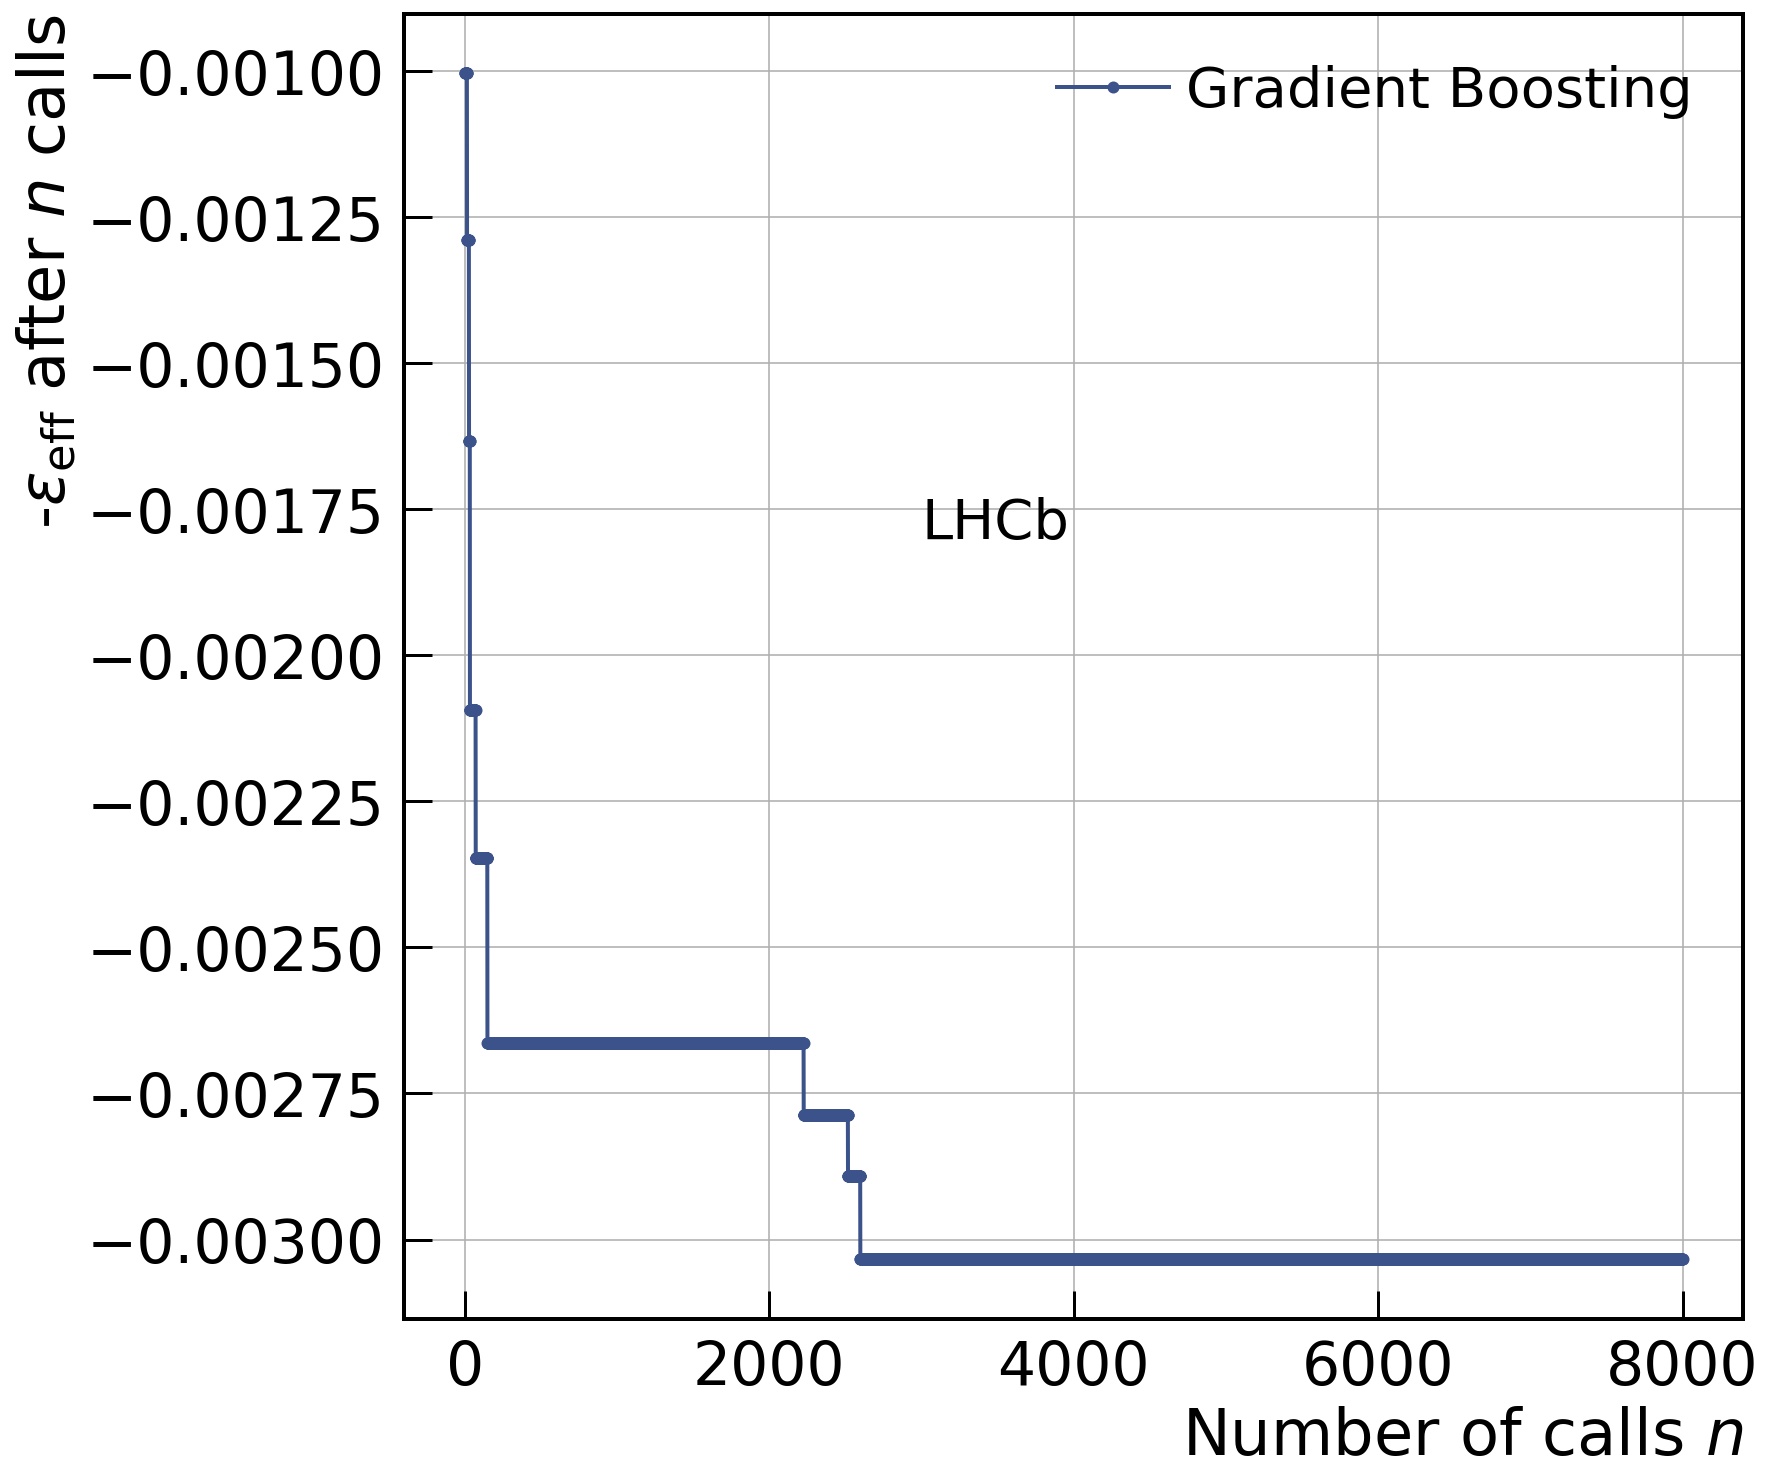

In [19]:
fig = plt.figure()
ax = plt.gca()
plot = plot_convergence(("Gradient Boosting", res_gbrt), ax=ax)
plot.set_title("")
plot.set_xlabel("Number of calls $n$", ha='right', x=1)
plot.set_ylabel(r"-$\epsilon_{\rm eff}$ after $n$ calls", ha='right', y=1)
plot.text(3000,-0.0018,"LHCb",{'size': 28})
plot.legend(loc="best");
#fig.show()
fig.savefig(fig_prefix + 'ConvergenceOSe2017-nominal.pdf')

### Check performance on the other samples (that will be used for the BDT training, testing, calibration)

In [20]:
tagpowercalc_electron_bdt = TagPowerCalc(df_selected_bdt, query_str_wph, N_evt_bdt)
tagpowercalc_electron_eval1 = TagPowerCalc(df_selected_eval1, query_str_wph, N_evt_eval1)
tagpowercalc_electron_eval2 = TagPowerCalc(df_selected_eval2, query_str_wph, N_evt_eval2)
tagpowercalc_electron_all = TagPowerCalc(pd.concat([df_selected_bdt,df_selected_eval1,df_selected_eval2]), 
                                         query_str_wph, 
                                         N_evt_bdt+N_evt_eval1+N_evt_eval2)

In [21]:
print('Performance on "BDT" set:')
print(-tagpowercalc_electron_bdt.evaluate(res_gbrt.x,True))
print('Performance on "BDT" set (max pt):')
print(-tagpowercalc_electron_bdt.evaluate(res_gbrt.x,True,True))
print('Performance on "eval" 1 set:')
print(-tagpowercalc_electron_eval1.evaluate(res_gbrt.x,True))
print('Performance on "eval" 1 set (max pt):')
print(-tagpowercalc_electron_eval1.evaluate(res_gbrt.x,True,True))
print('Performance on "eval" 2 set:')
print(-tagpowercalc_electron_eval2.evaluate(res_gbrt.x,True))
print('Performance on "eval" 2 set (max pt):')
print(-tagpowercalc_electron_eval2.evaluate(res_gbrt.x,True,True))
print('Performance on merged sets:')
print(-tagpowercalc_electron_all.evaluate(res_gbrt.x,True))
print('Performance on merged sets (max pt):')
print(-tagpowercalc_electron_all.evaluate(res_gbrt.x,True,True))

Performance on "BDT" set:
Total Candidates:    566948.5608852252
Selected Candidates: 14243.73545729589
Tagging Efficiency:  2.512+/-0.021%
Mistag Probability:  33.4+/-0.4%
Tagging Dilution:    33.2+/-0.8%
Tagging Power:       0.277+/-0.007%
0.00277410818409
Performance on "BDT" set (max pt):
Total Candidates:    566948.5608852252
Selected Candidates: 14243.73545729589
Tagging Efficiency:  2.512+/-0.021%
Mistag Probability:  33.2+/-0.4%
Tagging Dilution:    33.5+/-0.8%
Tagging Power:       0.283+/-0.007%
0.00282610507458
Performance on "eval" 1 set:
Total Candidates:    141892.89286606023
Selected Candidates: 3561.909847640176
Tagging Efficiency:  2.51+/-0.04%
Mistag Probability:  33.5+/-0.8%
Tagging Dilution:    33.0+/-1.6%
Tagging Power:       0.274+/-0.014%
0.00273902351287
Performance on "eval" 1 set (max pt):
Total Candidates:    141892.89286606023
Selected Candidates: 3561.909847640176
Tagging Efficiency:  2.51+/-0.04%
Mistag Probability:  33.3+/-0.8%
Tagging Dilution:    33.5+/-

In [22]:
#Apply selection and save dataframes to file
df_selected_bdt = df_selected_bdt.query(query_presel)
df_selected_bdt.reset_index().to_root(file_out_path_bdt)
df_selected_eval1 = df_selected_eval1.query(query_presel)
df_selected_eval1.reset_index().to_root(file_out_path_eval1)
df_selected_eval2 = df_selected_eval2.query(query_presel)
df_selected_eval2.reset_index().to_root(file_out_path_eval2)

### Finally, check the stability of the minimisation (change initial seed)

In [29]:
def run(minimizer, n_iter=10):
    return [minimizer(tagpowercalc_electron.evaluate, x0_gp_limits, n_calls=1000, random_state=n, x0=x0_gp, n_jobs=-1) 
            for n in range(n_iter)]

In [ ]:
res_gbrt_test = run(partial(gbrt_minimize))

In [14]:
#Read from file
#res_gbrt_test = load(weight_prefix+'GBRTobjectiveNominalOSe2017_ConvCheck.pkl')

In [ ]:
fig = plt.figure()
ax = plt.gca()
plot = plot_convergence(("Gradient Boosting (average)", res_gbrt_test))
plot.set_title("")
plot.set_xlabel("Number of calls $n$", ha='right', x=1)
plot.set_ylabel(r"-$\epsilon_{\rm eff}$ after $n$ calls", ha='right', y=1)
plot.text(500,-0.0018,"LHCb",{'size': 28})
plot.legend(loc="best");
#fig.show()
fig.savefig(fig_prefix + 'ConvergenceOSe2017Check-nominal.pdf')

In [33]:
#Dump result to file
dump(res_gbrt_test, weight_prefix+'GBRTobjectiveNominalOSe2017_ConvCheck.pkl', store_objective=True)